# CFD Output Visualization: Spectral Element Channel Flow
This notebook reads and visualizes the output from a Fortran spectral element CFD code. It includes:
- Reading mesh and velocity data from a formatted output file
- Streamline plots of the velocity field
- Mesh collocation point visualization
- Velocity profiles at specified locations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.widgets import Button
from functools import lru_cache  # For caching interpolation results

def add_coordinate_readout(fig, axes):
    """
    Add coordinate readout on mouse hover and click to a matplotlib figure.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to add coordinate readout to
    axes : matplotlib.axes.Axes or list of Axes
        The axes to monitor for mouse events
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The modified figure with coordinate readout capability
    """
    if not isinstance(axes, list):
        axes = [axes]
    
    # Create text display for hover coordinates
    hover_text = fig.text(0.01, 0.97, "", va="top", ha="left",
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Create text display for click coordinates
    coord_text = fig.text(0.01, 0.01, "", va="bottom", ha="left",
                         bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))
    
    # Create value display for clicked location
    value_text = fig.text(0.99, 0.01, "", va="bottom", ha="right",
                         bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.8))
    
    # Variables to store lines for cross-hairs
    vline, hline = None, None
    
    # Create a button to clear annotations
    ax_clear = plt.axes([0.45, 0.01, 0.1, 0.04])
    clear_button = Button(ax_clear, 'Clear')
    
    # List to store all annotations
    annotations = []
    
    def clear_all_annotations(event):
        """Clear all annotations from the plot"""
        nonlocal vline, hline
        
        # Clear coordinate and value displays
        coord_text.set_text("")
        value_text.set_text("")
        hover_text.set_text("")
        
        # Remove crosshair lines if they exist
        if vline:
            vline.remove()
            vline = None
        if hline:
            hline.remove()
            hline = None
        
        # Remove all point annotations
        for ann in annotations:
            ann.remove()
        annotations.clear()
        
        fig.canvas.draw_idle()
    
    # Connect clear button
    clear_button.on_clicked(clear_all_annotations)
    
    @lru_cache(maxsize=1000)
    def get_interpolated_value(ax, x, y):
        """Get interpolated data value at the given coordinates"""
        for artist in ax.get_children():
            # For contour plots, pcolormesh, etc.
            if hasattr(artist, 'get_array') and artist.get_array() is not None:
                try:
                    # Interpolate the value at the clicked point
                    z = artist.get_array()
                    xi = int(np.clip(x, 0, z.shape[1]-1))
                    yi = int(np.clip(y, 0, z.shape[0]-1))
                    x0, x1 = max(xi-1, 0), min(xi+1, z.shape[1]-1)
                    y0, y1 = max(yi-1, 0), min(yi+1, z.shape[0]-1)
                    value = griddata(((x0, y0), (x1, y0), (x0, y1), (x1, y1)),
                                    (z[y0, x0], z[y0, x1], z[y1, x0], z[y1, x1]),
                                    (x, y), method='linear')
                    return value
                except (IndexError, ValueError, TypeError):
                    return None
        return None
    
    def onclick(event):
        """Handle mouse click events in the plot"""
        nonlocal vline, hline
        
        # Check if click is within an axis
        if event.inaxes in axes:
            x, y = event.xdata, event.ydata
            
            # Update coordinate display
            coord_text.set_text(f"Click: x={x:.6f}, y={y:.6f}")
            
            # Try to get data value at click point
            ax = event.inaxes
            for artist in ax.get_children():
                # For contour plots, pcolormesh, etc.
                if hasattr(artist, 'get_array') and artist.get_array() is not None:
                    try:
                        value = artist.get_array()[int(event.ydata), int(event.xdata)]
                        value_text.set_text(f"Value: {value:.6f}")
                        break
                    except (IndexError, ValueError, TypeError):
                        value_text.set_text("Value: N/A")
            
            # Add a persistent annotation at the clicked point
            ann = ax.annotate(f"({x:.4f}, {y:.4f})", 
                             xy=(x, y), 
                             xytext=(10, 10),
                             textcoords="offset points",
                             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                             arrowprops=dict(arrowstyle="->"))
            annotations.append(ann)
            
            # Remove previous crosshair lines if they exist
            if vline:
                vline.remove()
            if hline:
                hline.remove()
            
            # Add new crosshair lines
            vline = ax.axvline(x=x, color='r', linestyle='--', alpha=0.5)
            hline = ax.axhline(y=y, color='r', linestyle='--', alpha=0.5)
            
            fig.canvas.draw_idle()
    
    def onmotion(event):
        """Handle mouse motion events to display current coordinates"""
        if event.inaxes in axes:
            x, y = event.xdata, event.ydata
            hover_text.set_text(f"x={x:.6f}, y={y:.6f}")
            
            # Optimize by reducing the frequency of canvas updates
            # Only update every few events to improve performance
            if getattr(onmotion, 'counter', 0) % 5 == 0:  # Update every 5 motion events
                fig.canvas.draw_idle()
            onmotion.counter = getattr(onmotion, 'counter', 0) + 1
        else:
            hover_text.set_text("")
    
    # Connect events to the figure
    fig.canvas.mpl_connect('button_press_event', onclick)
    fig.canvas.mpl_connect('motion_notify_event', onmotion)
    
    return fig

## Read Formatted Output
The following function reads mesh and velocity data from the formatted output file (`cavity_run.dat`).

In [2]:
def read_formatted_output(filename):
    """
    Read formatted output file from spectral element CFD simulation.
    
    This function can handle both legacy format (5 parameters) and enhanced modern format (2 parameters).
    
    Parameters
    ----------
    filename : str
        Path to the output file
        
    Returns
    -------
    xp, yp : numpy arrays
        Arrays containing the x and y coordinates of collocation points
    u, v : numpy arrays
        Arrays containing u and v velocity components at each collocation point
    p, om : numpy arrays
        Arrays containing pressure and vorticity values at each collocation point
    nterm : int
        Number of collocation points in each dimension per element
    nelem : int
        Total number of elements
    """
    # Read the entire file at once for better performance
    with open(filename, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    # First line contains time and Reynolds number
    first_line_parts = lines[0].split()
    time = float(first_line_parts[0])
    re = float(first_line_parts[1])
    
    # Second line contains parameters
    params = lines[1].split()
    nelem = int(params[0])  # Number of elements
    
    # Check if this is enhanced modern format (2 params) or legacy format (5 params)
    if len(params) == 2:
        # Enhanced modern format: nelem, nterm
        nterm = int(params[1])   # Number of collocation points per element dimension
        ndep = 6  # x, y, u, v, p, vorticity (6 values per point)
        print(f"Enhanced modern format: time={time}, nelem={nelem}, nterm={nterm}")
        
        # Initialize arrays with correct dimensions
        # For enhanced modern format, we have a simpler data structure
        total_points = nelem * nterm * nterm
        xp = np.zeros(total_points)
        yp = np.zeros(total_points)
        u = np.zeros(total_points)
        v = np.zeros(total_points)
        p = np.zeros(total_points)
        om = np.zeros(total_points)
        
        # Read data line by line starting from line 3
        point_idx = 0
        for line_idx in range(2, len(lines)):
            values = [float(val) for val in lines[line_idx].split()]
            if len(values) >= 6:  # x, y, u, v, p, vorticity
                xp[point_idx] = values[0]
                yp[point_idx] = values[1]
                u[point_idx] = values[2]
                v[point_idx] = values[3]
                p[point_idx] = values[4]
                om[point_idx] = values[5]
                point_idx += 1
                if point_idx >= total_points:
                    break
        
        # Reshape arrays to match expected format (nterm, nterm, nelem)
        u_3d = np.zeros((nterm, nterm, nelem))
        v_3d = np.zeros((nterm, nterm, nelem))
        p_3d = np.zeros((nterm, nterm, nelem))
        om_3d = np.zeros((nterm, nterm, nelem))
        xp_2d = np.zeros((nterm, nelem))
        yp_2d = np.zeros((nterm, nelem))
        
        # Reorganize data by element
        point_idx = 0
        for ne in range(nelem):
            for j in range(nterm):
                for i in range(nterm):
                    if point_idx < len(u):
                        u_3d[i, j, ne] = u[point_idx]
                        v_3d[i, j, ne] = v[point_idx]
                        p_3d[i, j, ne] = p[point_idx]
                        om_3d[i, j, ne] = om[point_idx]
                        if i == 0:  # Store x,y coordinates once per j
                            xp_2d[j, ne] = xp[point_idx]
                            yp_2d[j, ne] = yp[point_idx]
                        point_idx += 1
        
        return xp_2d, yp_2d, u_3d, v_3d, p_3d, om_3d, nterm, nelem, time, re
    
    else:
        # Legacy format with 5 parameters
        neig = int(params[1])   # Number of eigenvalues (not used)
        nterm = int(params[2])  # Number of collocation points per element dimension
        ndep = int(params[3])   # Number of dependent variables (u, v, p)
        nee = int(params[4])    # Total number of values per element
        
        print(f"Legacy format: time={time}, nelem={nelem}, neig={neig}, nterm={nterm}, ndep={ndep}, nee={nee}")
        
        # Initialize arrays with correct dimensions
        xp = np.zeros((nterm, nelem))
        yp = np.zeros((nterm, nelem))
        u = np.zeros((nterm, nterm, nelem))
        v = np.zeros((nterm, nterm, nelem))
        p = np.zeros((nterm, nterm, nelem))
        om = np.zeros((nterm, nterm, nelem))    
        
        # Track current line index
        line_idx = 2
        
        # Process data for each element (legacy format processing)
        for ne in range(nelem):
            # Read x-coordinates (nterm values)
            x_values = []
            while len(x_values) < nterm and line_idx < len(lines):
                values = [float(val) for val in lines[line_idx].split()]
                x_values.extend(values)
                line_idx += 1
            xp[:, ne] = x_values[:nterm]  # Store x-coordinates for this element
            
            # Read y-coordinates (nterm values)
            y_values = []
            while len(y_values) < nterm and line_idx < len(lines):
                values = [float(val) for val in lines[line_idx].split()]
                y_values.extend(values)
                line_idx += 1
            yp[:, ne] = y_values[:nterm]  # Store y-coordinates for this element
            
            # Read velocity field values
            field_values = []
            target_len = nterm * nterm * ndep
            while len(field_values) < target_len and line_idx < len(lines):
                values = [float(val) for val in lines[line_idx].split()]
                field_values.extend(values)
                line_idx += 1
            
            # Convert field_values to a numpy array for faster reshaping
            field_values_np = np.array(field_values[:target_len])
            
            # Skip dummy values
            dummy_lines = 0
            dummy_count = 0
            while dummy_count < target_len and line_idx < len(lines):
                dummy_count += len(lines[line_idx].split())
                line_idx += 1
                dummy_lines += 1

            # Skip dummy values
            dummy_lines = 0
            dummy_count = 0
            while dummy_count < target_len and line_idx < len(lines):
                dummy_count += len(lines[line_idx].split())
                line_idx += 1
                dummy_lines += 1    
            
            # Skip boundary condition info
            line_idx += 2
            
            # Process the field values (faster with numpy operations)
            field_idx = 0
            for i in range(nterm):
                for j in range(nterm):
                    if field_idx < len(field_values_np):
                        u[i, j, ne] = field_values_np[field_idx]
                        if field_idx + 1 < len(field_values_np):
                            v[i, j, ne] = field_values_np[field_idx + 1]
                        if field_idx + 2 < len(field_values_np):
                            p[i, j, ne] = field_values_np[field_idx + 2]
                        if ndep >= 4 and field_idx + 3 < len(field_values_np):
                            om[i, j, ne] = field_values_np[field_idx + 3]
                    field_idx += ndep
        
        return xp, yp, u, v, p, om, nterm, nelem, time, re

In [3]:



filename = "cavity_run_36_7_Re1000.dat"

xp, yp, u, v, p, om, nterm, nelem, time_val, re = read_formatted_output(filename)
print(f"Successfully loaded data: {nelem} elements with {nterm} points each at Re = {re}")
print(f"Simulation time: {time_val}")


for ne in range(nelem):
    print(f"Element {ne}:")
    print("x-coordinates:", xp[:, ne])
    print("y-coordinates:", yp[:, ne])
    #print("u-coordinates:", u[:, :, ne])
    #print("v-coordinates:", v[:, :, ne])

for ne in range(nelem):
    print(f"Element {ne}:")  
    print("u-velocity:", u[:, -1 , ne])  


Legacy format: time=100.0, nelem=36, neig=49, nterm=7, ndep=4, nee=196
Successfully loaded data: 36 elements with 7 points each at Re = 1000.0
Simulation time: 100.0
Element 0:
x-coordinates: [0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
y-coordinates: [0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 1:
x-coordinates: [0.1      0.108489 0.126558 0.15     0.173442 0.191511 0.2     ]
y-coordinates: [0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 2:
x-coordinates: [0.2      0.225466 0.279673 0.35     0.420327 0.474534 0.5     ]
y-coordinates: [0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 3:
x-coordinates: [0.5      0.525466 0.579673 0.65     0.720327 0.774534 0.8     ]
y-coordinates: [0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 4:
x-coordinates: [0.8      0.808489 0.826558 0.85     0.873442 0.891511

## All Meshgrids with Collocation Points
Show the meshgrid for each element with collocation points.

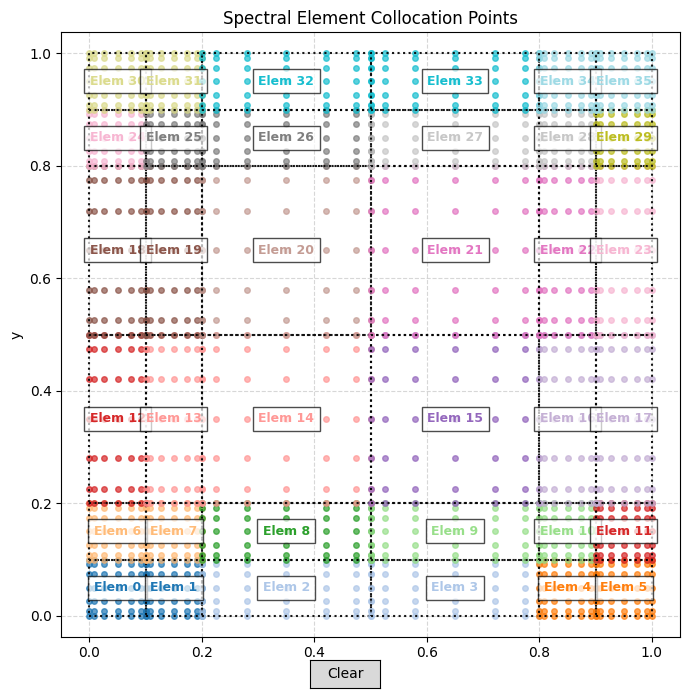

In [4]:
plt.figure(figsize=(7, 7))
colors = plt.cm.tab20(np.linspace(0, 1, nelem))

for ne in range(nelem):
    # Create a meshgrid of collocation points for this element
    x_elem = xp[:, ne]
    y_elem = yp[:, ne]
    
    # Get element boundaries
    x_min, x_max = np.min(x_elem), np.max(x_elem)
    y_min, y_max = np.min(y_elem), np.max(y_elem)
    
    # Plot all combinations of x and y coordinates as collocation points
    for i in range(nterm):
        for j in range(nterm):
            plt.plot(x_elem[i], y_elem[j], 'o', color=colors[ne], markersize=4, alpha=0.7)
    
    # Draw element boundary as a quadrilateral
    x_corners = [x_min, x_max, x_max, x_min, x_min]
    y_corners = [y_min, y_min, y_max, y_max, y_min]
    plt.plot(x_corners, y_corners, 'k:', linewidth=1.5, alpha=0.9)
    
    # Add element label at the centroid
    centroid_x = (x_min + x_max) / 2
    centroid_y = (y_min + y_max) / 2
    plt.text(centroid_x, centroid_y, f'Elem {ne}', 
             color=colors[ne], fontsize=9, ha='center', va='center', 
             weight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('x')
plt.ylabel('y')
plt.title('Spectral Element Collocation Points')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Add coordinate readout capability
fig = plt.gcf()
ax = plt.gca()
add_coordinate_readout(fig, ax)

plt.show()

## Plot Velocity Field Element by Element
This function visualizes the velocity field for each element individually, overlaying the local vector field on the mesh for each element. Each element is shown in a different color for clarity.

/var/folders/49/537_h6nd37740hj1p096c30w0000gn/T/ipykernel_2237/2532088182.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


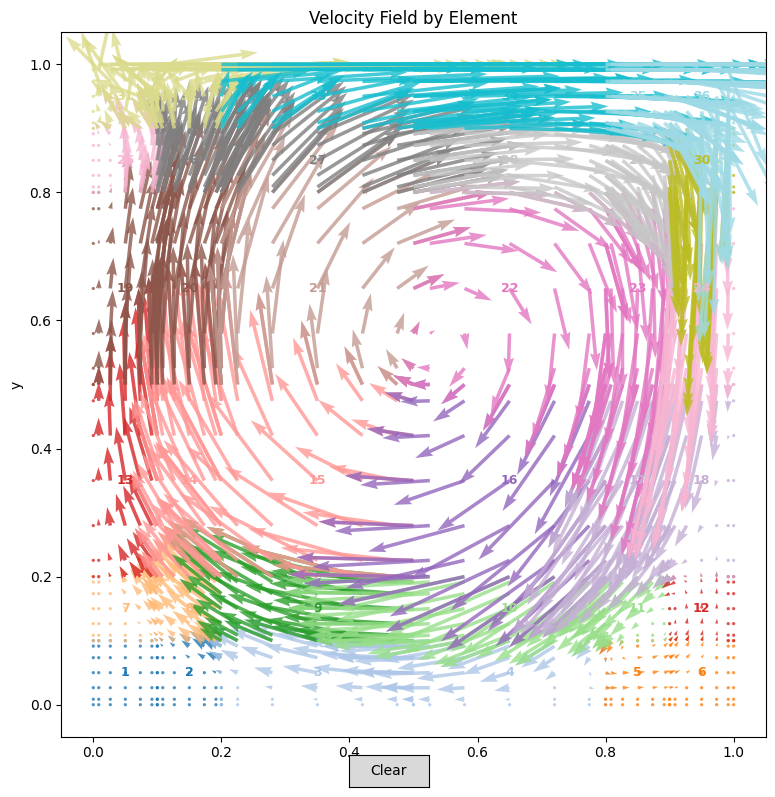

In [5]:
def plot_velocity_by_element(xp, yp, u, v, nelem, nterm, scale=0.1):
    """
    Plot the velocity field for each element using quiver plots.
    Each element is shown in a different color.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    u, v : arrays
        Velocity components at each collocation point
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    scale : float
        Scaling factor for the arrows (higher = longer arrows)
        
    Note:
    -----
    This function uses a simple interpolation method that doesn't fully leverage the spectral accuracy
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    colors = plt.cm.tab20(np.linspace(0, 1, nelem))
    for ne in range(nelem):
        # Meshgrid for this element
        x = xp[:, ne]
        y = yp[:, ne]
        uu = u[:, :, ne]
        vv = v[:, :, ne]
        # Create meshgrid for plotting
        X, Y = np.meshgrid(x, y, indexing='ij')
        # Plot velocity vectors (quiver)
        ax.quiver(X, Y, uu, vv, color=colors[ne], scale=1/scale, width=0.005, alpha=0.8)
        # Optionally, plot the element boundary
        #plt.plot(x, y, 'o-', color=colors[ne], label=f'Elem {ne+1}')
        # Label the element at its centroid
        ax.text(np.mean(x), np.mean(y), f'{ne+1}', color=colors[ne], fontsize=9, ha='center', va='center', weight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Velocity Field by Element')
    ax.set_aspect('equal')
    ax.grid(False)
    
    # Add coordinate readout capability
    add_coordinate_readout(fig, ax)
    
    plt.tight_layout()
    plt.show()

# Example usage with the current data
plot_velocity_by_element(xp, yp, u, v, nelem, nterm, scale=0.5)

## Plot Streamlines Element by Element
This function visualizes the velocity field streamlines for each element individually, interpolating from the collocation points to a uniform mesh for each element to create smoother streamlines.

/var/folders/49/537_h6nd37740hj1p096c30w0000gn/T/ipykernel_2237/3144965374.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


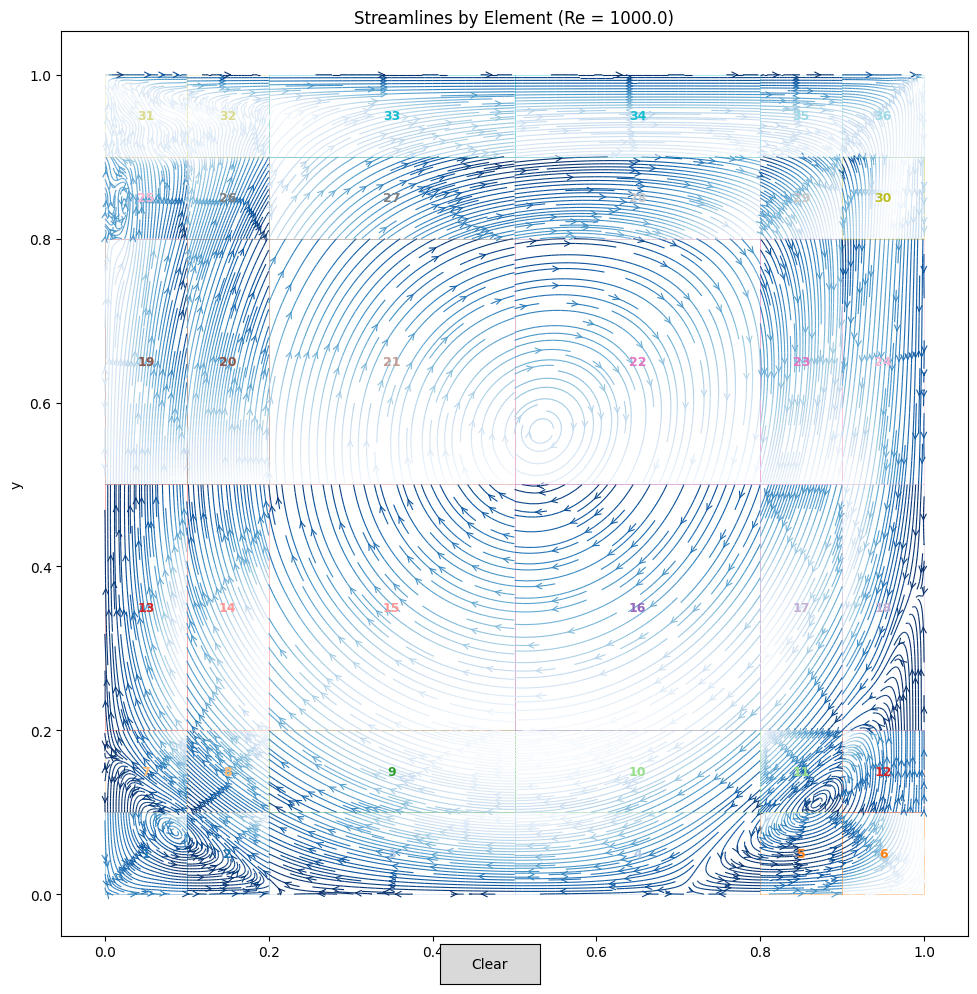

In [6]:
def plot_streamlines_by_element(xp, yp, u, v, nelem, nterm, re, density=1.0, n_grid=100):
    """
    Plot streamlines for each element by interpolating to a uniform mesh.
    Optimized with caching for better performance.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    u, v : arrays
        Velocity components at each collocation point
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    re : float
        Reynolds number of the simulation
    density : float
        Density of streamlines (higher values = more streamlines)
    n_grid : int
        Size of uniform grid for interpolation (n_grid x n_grid)
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    colors = plt.cm.tab20(np.linspace(0, 1, nelem))
    
    # Use function caching for better performance
    @lru_cache(maxsize=32)
    def interpolate_element(ne, n_grid):
        """Cache-enabled interpolation function"""
        # Get element bounds
        x_min, x_max = np.min(xp[:, ne]), np.max(xp[:, ne])
        y_min, y_max = np.min(yp[:, ne]), np.max(yp[:, ne])
        
        # Create uniform grid for this element
        x_lin = np.linspace(x_min, x_max, n_grid)
        y_lin = np.linspace(y_min, y_max, n_grid)
        X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='xy')
        
        # Prepare points for interpolation
        points = []
        values_u = []
        values_v = []
        
        # Gather points and values for this element - using the tensor product of collocation points
        for i in range(nterm):
            for j in range(nterm):
                x_point = xp[i, ne]
                y_point = yp[j, ne]
                points.append([x_point, y_point])
                values_u.append(u[i, j, ne])
                values_v.append(v[i, j, ne])
        
        # Convert to numpy arrays for faster processing
        points = np.array(points)
        values_u = np.array(values_u)
        values_v = np.array(values_v)
        
        # Reshape the grid for interpolation
        grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
        
        # Use cubic interpolation if enough points, otherwise linear
        method = 'cubic' if nterm > 3 else 'linear'
        
        # Interpolate u and v to the uniform grid
        U_grid = griddata(points, values_u, grid_points, method=method)
        V_grid = griddata(points, values_v, grid_points, method=method)
        
        # Reshape back to grid format
        U_grid = U_grid.reshape(X_grid.shape)
        V_grid = V_grid.reshape(X_grid.shape)
        
        return X_grid, Y_grid, U_grid, V_grid, [x_min, x_max, y_min, y_max]
    
    # Process each element
    for ne in range(nelem):
        # Get interpolated data
        X_grid, Y_grid, U_grid, V_grid, bounds = interpolate_element(ne, n_grid)
        x_min, x_max, y_min, y_max = bounds
        
        # Create mask for data within element boundaries
        mask = np.ones_like(X_grid, dtype=bool)
        
        # Apply mask to the grid data
        X_masked = np.ma.masked_array(X_grid, ~mask)
        Y_masked = np.ma.masked_array(Y_grid, ~mask)
        U_masked = np.ma.masked_array(U_grid, ~mask)
        V_masked = np.ma.masked_array(V_grid, ~mask)
        
        # Draw element boundary
        ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 
                '-', color=colors[ne], alpha=0.5, linewidth=0.5)
        
        # Plot streamlines for this element
        # Use color parameter differently to avoid shape mismatch error
        streamplot = ax.streamplot(X_masked, Y_masked, U_masked, V_masked, 
                                 color=U_masked, # Use velocity as color, with specific color mapping
                                 cmap=plt.cm.Blues, # Use a colormap
                                 linewidth=0.8, density=density, 
                                 arrowstyle='->', arrowsize=1.0)
        
        # Label the element at its centroid
        ax.text(np.mean([x_min, x_max]), np.mean([y_min, y_max]), 
                f'{ne+1}', color=colors[ne], fontsize=9, 
                ha='center', va='center', weight='bold')
    
    # Add axes labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Streamlines by Element (Re = {re:.1f})')
    ax.set_aspect('equal')
    ax.grid(False)
    
    # Add coordinate readout capability
    add_coordinate_readout(fig, ax)
    
    plt.tight_layout()
    plt.show()

# Example usage with the current data
plot_streamlines_by_element(xp, yp, u, v, nelem, nterm, re, density=1.0)

/Users/danielchan/opt/anaconda3/envs/CFD/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


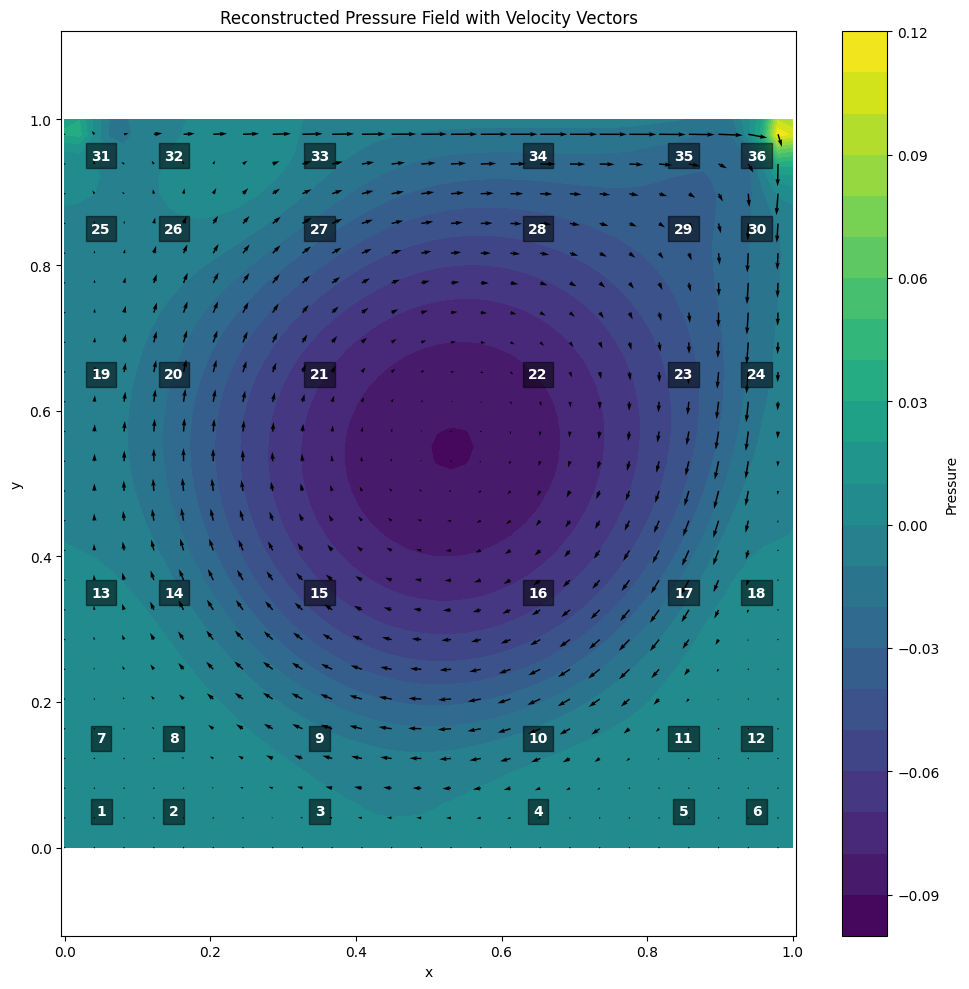

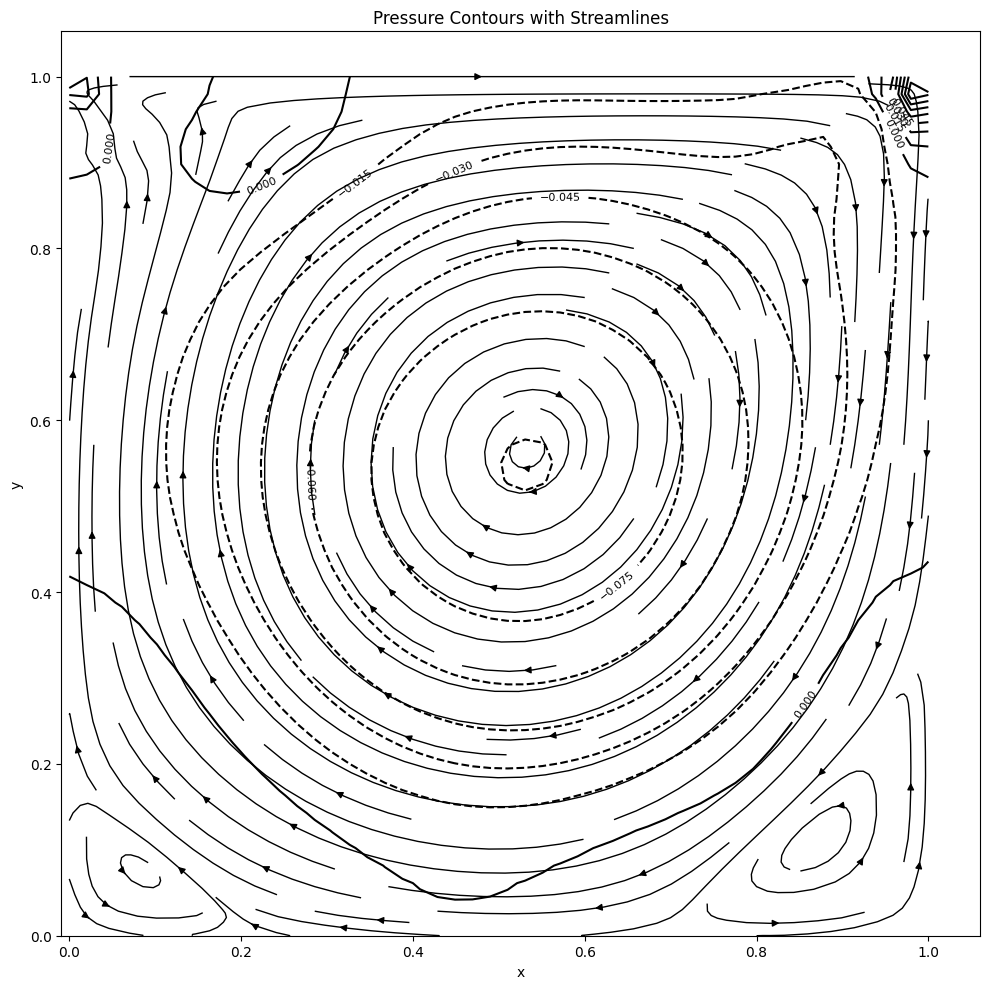

In [7]:
def reconstruct_pressure(xp, yp, u, v, nelem, nterm, n_grid=50):
    """
    Reconstruct the pressure field from velocity data by solving
    the Poisson equation using finite differences.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    u, v : arrays
        Velocity components at each collocation point
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    n_grid : int
        Size of uniform grid for interpolation (n_grid x n_grid)
    """
    from scipy.sparse import diags, lil_matrix, csr_matrix
    from scipy.sparse.linalg import spsolve
    
    # Collect all points and velocity values
    all_points = []
    all_u = []
    all_v = []
    
    for ne in range(nelem):
        for i in range(nterm):
            for j in range(nterm):
                all_points.append([xp[i, ne], yp[j, ne]])
                all_u.append(u[i, j, ne])
                all_v.append(v[i, j, ne])
    
    all_points = np.array(all_points)
    all_u = np.array(all_u)
    all_v = np.array(all_v)
    
    # Create uniform grid for the entire domain
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    
    x_lin = np.linspace(x_min, x_max, n_grid)
    y_lin = np.linspace(y_min, y_max, n_grid)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='xy')
    
    # Interpolate velocity components to uniform grid
    U_grid = griddata(all_points, all_u, (X_grid, Y_grid), method='cubic', fill_value=0)
    V_grid = griddata(all_points, all_v, (X_grid, Y_grid), method='cubic', fill_value=0)
    
    # Calculate derivatives for source term in Poisson equation
    dx = x_lin[1] - x_lin[0]
    dy = y_lin[1] - y_lin[0]
    
    # First derivatives
    du_dx = np.zeros_like(U_grid)
    du_dy = np.zeros_like(U_grid)
    dv_dx = np.zeros_like(V_grid)
    dv_dy = np.zeros_like(V_grid)
    
    # Interior points (central differences)
    du_dx[1:-1, 1:-1] = (U_grid[1:-1, 2:] - U_grid[1:-1, :-2]) / (2 * dx)
    du_dy[1:-1, 1:-1] = (U_grid[2:, 1:-1] - U_grid[:-2, 1:-1]) / (2 * dy)
    dv_dx[1:-1, 1:-1] = (V_grid[1:-1, 2:] - V_grid[1:-1, :-2]) / (2 * dx)
    dv_dy[1:-1, 1:-1] = (V_grid[2:, 1:-1] - V_grid[:-2, 1:-1]) / (2 * dy)
    
    # Boundary derivatives (one-sided differences)
    # We'll simplify by just copying from adjacent interior points
    du_dx[0, :] = du_dx[1, :]
    du_dx[-1, :] = du_dx[-2, :]
    du_dx[:, 0] = du_dx[:, 1]
    du_dx[:, -1] = du_dx[:, -2]
    
    du_dy[0, :] = du_dy[1, :]
    du_dy[-1, :] = du_dy[-2, :]
    du_dy[:, 0] = du_dy[:, 1]
    du_dy[:, -1] = du_dy[:, -2]
    
    dv_dx[0, :] = dv_dx[1, :]
    dv_dx[-1, :] = dv_dx[-2, :]
    dv_dx[:, 0] = dv_dx[:, 1]
    dv_dx[:, -1] = dv_dx[:, -2]
    
    dv_dy[0, :] = dv_dy[1, :]
    dv_dy[-1, :] = dv_dy[-2, :]
    dv_dy[:, 0] = dv_dy[:, 1]
    dv_dy[:, -1] = dv_dy[:, -2]
    
    # Source term for Poisson equation: S = -ρ(du/dx*du/dx + 2*du/dy*dv/dx + dv/dy*dv/dy)
    # We set density ρ=1 for simplicity
    source = -(du_dx**2 + 2*du_dy*dv_dx + dv_dy**2)
    
    # Reshape source term to 1D array
    source_1d = source.flatten()
    
    # Create sparse matrix for Poisson equation (5-point stencil Laplacian)
    N = n_grid
    n_points = N * N
    
    # Initialize the coefficient matrix in LIL format (efficient for construction)
    A = lil_matrix((n_points, n_points))
    
    # Fill the coefficient matrix
    for i in range(N):
        for j in range(N):
            idx = i * N + j
            
            # Set diagonal coefficient
            A[idx, idx] = -4
            
            # Set off-diagonal coefficients (neighboring points)
            if i > 0:  # bottom neighbor
                A[idx, (i-1)*N + j] = 1
            if i < N-1:  # top neighbor
                A[idx, (i+1)*N + j] = 1
            if j > 0:  # left neighbor
                A[idx, i*N + (j-1)] = 1
            if j < N-1:  # right neighbor
                A[idx, i*N + (j+1)] = 1
    
    # Convert to CSR format (efficient for solving)
    A = A.tocsr()
    
    # Scale by grid spacing
    A = A / (dx**2)
    
    # Fix one point (pressure at bottom left corner = 0) to make the solution unique
    A[0, :] = 0
    A[0, 0] = 1
    source_1d[0] = 0
    
    # Solve the system
    pressure_1d = spsolve(A, source_1d)
    
    # Reshape the solution to 2D grid
    pressure = pressure_1d.reshape((N, N))
    
    # Plot the pressure field
    plt.figure(figsize=(10, 10))
    
    # Plot filled contours for pressure
    levels = 20
    contour = plt.contourf(X_grid, Y_grid, pressure, levels=levels, cmap='viridis')
    plt.colorbar(contour, label='Pressure')
    
    # Plot velocity vectors over pressure field
    skip = 2  # Skip some points for clarity
    plt.quiver(X_grid[::skip, ::skip], Y_grid[::skip, ::skip], 
               U_grid[::skip, ::skip], V_grid[::skip, ::skip], 
               color='k', scale=20, width=0.002)
    
    # Plot element boundaries
    colors = plt.cm.tab20(np.linspace(0, 1, nelem))
    for ne in range(nelem):
        # Add element label at centroid
        centroid_x = np.mean(xp[:, ne])
        centroid_y = np.mean(yp[:, ne])
        plt.text(centroid_x, centroid_y, f'{ne+1}', 
                 color='w', fontsize=10, 
                 ha='center', va='center', 
                 weight='bold', bbox=dict(facecolor='black', alpha=0.5))
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Reconstructed Pressure Field with Velocity Vectors')
    plt.axis('equal')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # Also plot pressure contour lines with streamlines
    plt.figure(figsize=(10, 10))
    contour = plt.contour(X_grid, Y_grid, pressure, levels=15, colors='k')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.streamplot(X_grid, Y_grid, U_grid, V_grid, color='k', density=1.2, linewidth=1, arrowsize=1)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pressure Contours with Streamlines')
    plt.axis('equal')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    return pressure, X_grid, Y_grid

# Example usage
pressure, X_grid, Y_grid = reconstruct_pressure(xp, yp, u, v, nelem, nterm, n_grid=50)


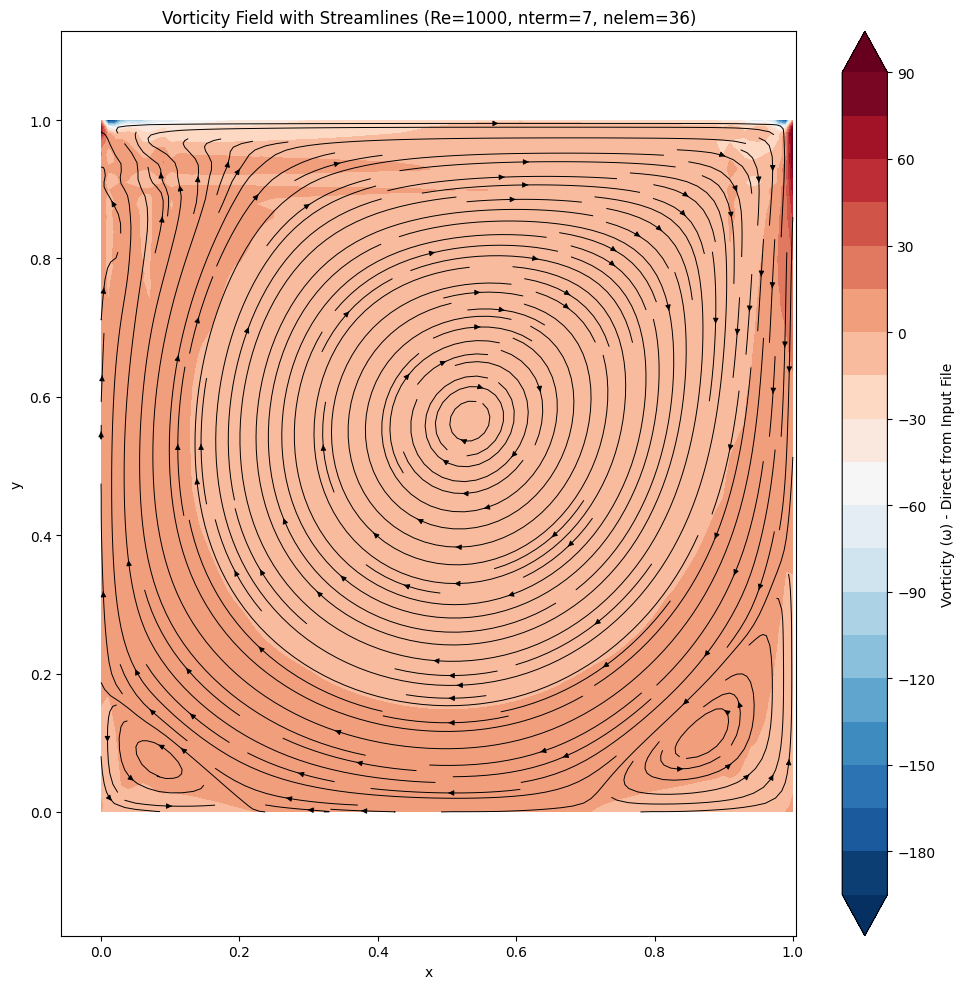

Min vorticity: -205.043642
Max vorticity: 101.607615
Mean absolute vorticity: 3.151778


In [8]:
def plot_vorticity_direct(xp, yp, om, u, v, nelem, nterm, re, n_grid=100):
    """
    Plot the vorticity field using the pre-calculated vorticity data from the input file.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    om : array
        Vorticity values at each collocation point
    u, v : arrays
        Velocity components at each collocation point (for streamlines)
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    re : float
        Reynolds number of the simulation
    n_grid : int
        Size of uniform grid for interpolation (n_grid x n_grid)
    """
    # Collect all points and field values
    all_points = []
    all_om = []
    all_u = []
    all_v = []
    
    for ne in range(nelem):
        for i in range(nterm):
            for j in range(nterm):
                all_points.append([xp[i, ne], yp[j, ne]])
                all_om.append(om[i, j, ne])
                all_u.append(u[i, j, ne])
                all_v.append(v[i, j, ne])
    
    all_points = np.array(all_points)
    all_om = np.array(all_om)
    all_u = np.array(all_u)
    all_v = np.array(all_v)
    
    # Create uniform grid for the entire domain
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    
    x_lin = np.linspace(x_min, x_max, n_grid)
    y_lin = np.linspace(y_min, y_max, n_grid)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='xy')
    
    # Interpolate vorticity and velocity components to uniform grid
    OM_grid = griddata(all_points, all_om, (X_grid, Y_grid), method='cubic', fill_value=0)
    U_grid = griddata(all_points, all_u, (X_grid, Y_grid), method='cubic', fill_value=0)
    V_grid = griddata(all_points, all_v, (X_grid, Y_grid), method='cubic', fill_value=0)
    
    # Plot vorticity contours
    plt.figure(figsize=(10, 10))
    
    # Plot filled contours for vorticity
    levels = 20
    contour = plt.contourf(X_grid, Y_grid, OM_grid, levels=levels, cmap='RdBu_r', extend='both')
    plt.colorbar(contour, label='Vorticity (ω) - Direct from Input File')
    
    # Plot streamlines over vorticity
    plt.streamplot(X_grid, Y_grid, U_grid, V_grid, color='k', density=2., linewidth=0.7, arrowsize=0.8)
    
    # Element boundaries and labels removed as requested
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Vorticity Field with Streamlines (Re={re:.0f}, nterm={nterm}, nelem={nelem})')
    plt.axis('equal')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about vorticity
    print(f"Min vorticity: {np.min(OM_grid):.6f}")
    print(f"Max vorticity: {np.max(OM_grid):.6f}")
    print(f"Mean absolute vorticity: {np.mean(np.abs(OM_grid)):.6f}")
    
    return OM_grid

# Example usage
vorticity_grid = plot_vorticity_direct(xp, yp, om, u, v, nelem, nterm, re, n_grid=100)

In [9]:
import numpy as np

# y-coordinates (same for all Re cases for u-velocity at x=0.5)
ghia_y = np.array([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000,
                   0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000])

# x-coordinates (same for all Re cases for v-velocity at y=0.5, ordered 0 to 1)
ghia_x = np.array([0.0000, 0.0625, 0.0703, 0.0781, 0.0938, 0.1563, 0.2266, 0.2344, 0.5000,
                   0.8047, 0.8594, 0.9063, 0.9453, 0.9531, 0.9609, 0.9688, 1.0000])

# --- Re = 100 ---
ghia_y_100 = ghia_y
ghia_u_100 = np.array([1.00000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641,
                       -0.20581, -0.21090, -0.15662, -0.10150, -0.06434, -0.04775, -0.04192,
                       -0.03717, 0.00000])
ghia_x_100 = ghia_x
ghia_v_100 = np.array([0.00000, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527,
                       0.05454, -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391,
                       -0.05906, 0.00000])

# --- Re = 400 ---
ghia_y_400 = ghia_y
ghia_u_400 = np.array([1.00000, 0.75837, 0.68439, 0.61756, 0.55892, 0.29093, 0.16256, 0.02135,
                       -0.11477, -0.17119, -0.32726, -0.24299, -0.14612, -0.10338, -0.09266,
                       -0.08186, 0.00000])
ghia_x_400 = ghia_x
ghia_v_400 = np.array([0.00000, 0.18360, 0.19713, 0.20920, 0.22965, 0.28124, 0.30203, 0.30174,
                       0.05186, -0.38598, -0.44993, -0.23827, -0.22847, -0.19254, -0.15663,
                       -0.12146, 0.00000])

# --- Re = 1000 ---
ghia_y_1000 = ghia_y
ghia_u_1000 = np.array([1.00000, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702,
                        -0.06080, -0.10648, -0.27805, -0.38289, -0.29730, -0.22220, -0.20196,
                        -0.18109, 0.00000])
ghia_x_1000 = ghia_x
ghia_v_1000 = np.array([0.00000, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235,
                        0.02526, -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669,
                        -0.21388, 0.00000])

# --- Re = 3200 ---
ghia_y_3200 = ghia_y
ghia_u_3200 = np.array([1.00000, 0.53236, 0.48296, 0.46547, 0.46101, 0.34682, 0.19791, 0.07156,
                        -0.04272, -0.86636, -0.24427, -0.34323, -0.41933, -0.37827, -0.35344,
                        -0.32407, 0.00000])
ghia_u_3200 = np.array([1.00000, 0.53236, 0.48296, 0.46547, 0.46101, 0.34682, 0.19791, 0.07156,
                        -0.04272, -0.086636, -0.24427, -0.34323, -0.41933, -0.37827, -0.35344,
                        -0.32407, 0.00000])
ghia_x_3200 = ghia_x
ghia_v_3200 = np.array([0.00000, 0.39560, 0.40917, 0.41906, 0.42768, 0.37119, 0.29030, 0.28188,
                        0.00999, -0.31184, -0.37401, -0.44307, -0.54053, -0.52357, -0.47425,
                        -0.39017, 0.00000])


# --- Re = 10000 ---
ghia_y_10000 = ghia_y
ghia_u_10000 = np.array([1.00000, 0.47221, 0.47783, 0.48070, 0.47804, 0.34635, 0.20673, 0.08344,
                         0.03111, -0.07540, -0.23186, -0.32709, -0.38000, -0.41657, -0.42537,
                         -0.42735, 0.00000])
ghia_x_10000 = ghia_x
ghia_v_10000 = np.array([0.00000, 0.43983, 0.43733, 0.43124, 0.41487, 0.35070, 0.28003, 0.27224,
                         0.00831, -0.30719, -0.36737, -0.41496, -0.45863, -0.49099, -0.52987,
                         -0.54302, 0.00000])


# Ghia et al. data selection based on Reynolds number
ghia_data = {
        100: {'y': ghia_y_100, 'u': ghia_u_100, 'x': ghia_x_100, 'v': ghia_v_100},
        400: {'y': ghia_y_400, 'u': ghia_u_400, 'x': ghia_x_400, 'v': ghia_v_400},
        1000: {'y': ghia_y_1000, 'u': ghia_u_1000, 'x': ghia_x_1000, 'v': ghia_v_1000},
        3200: {'y': ghia_y_3200, 'u': ghia_u_3200, 'x': ghia_x_3200, 'v': ghia_v_3200},
        #5000: {'y': ghia_y_5000, 'u': ghia_u_5000, 'x': ghia_x_5000, 'v': ghia_v_5000},
        #7500: {'y': ghia_y_7500, 'u': ghia_u_7500, 'x': ghia_x_7500, 'v': ghia_v_7500},
        10000: {'y': ghia_y_10000, 'u': ghia_u_10000, 'x': ghia_x_10000, 'v': ghia_v_10000}
    }

In [10]:
def legendre_gauss_lobatto_points(n):
    """
    Calculates the n Legendre-Gauss-Lobatto (LGL) points and weights in the interval [-1, 1].

    The LGL points are the roots of the polynomial (1-x^2) * P'_{N}(x),
    where P_N(x) is the Legendre polynomial of degree N = n-1.

    Args:
        n (int): The number of LGL points to generate. Must be >= 2.

    Returns:
        tuple: (points, weights) - sorted arrays of n LGL points and their quadrature weights
    """
    from scipy.special import legendre
    
    if not isinstance(n, int) or n < 2:
        raise ValueError("Number of points n must be an integer greater than or equal to 2.")

    if n == 2:
        return np.array([-1.0, 1.0]), np.array([1.0, 1.0])

    # Degree of the Legendre polynomial
    N = n - 1

    # Get the Legendre polynomial P_N(x)
    P_N = legendre(N)

    # Get the derivative P'_N(x)
    P_N_prime = P_N.deriv()

    # The roots of P'_N(x) are the interior LGL points
    interior_points = P_N_prime.roots

    # Combine endpoints and interior points and sort them
    lgl_points = np.concatenate(([-1.0], np.sort(interior_points), [1.0]))

    # Ensure endpoints are exactly -1 and 1
    lgl_points[0] = -1.0
    lgl_points[-1] = 1.0
    
    # Calculate quadrature weights
    w = np.zeros(n)
    for i in range(n):
        P_N_val = P_N(lgl_points[i])
        w[i] = 2.0 / (n * (n-1) * P_N_val**2)

    return lgl_points, w


--- Comparison with Ghia's Data (Re=1000.0) - Fixed Interpolation ---
U-velocity RMSE: 0.012712
V-velocity RMSE: 0.012952
U-velocity maximum absolute error: 0.031221
V-velocity maximum absolute error: 0.024436


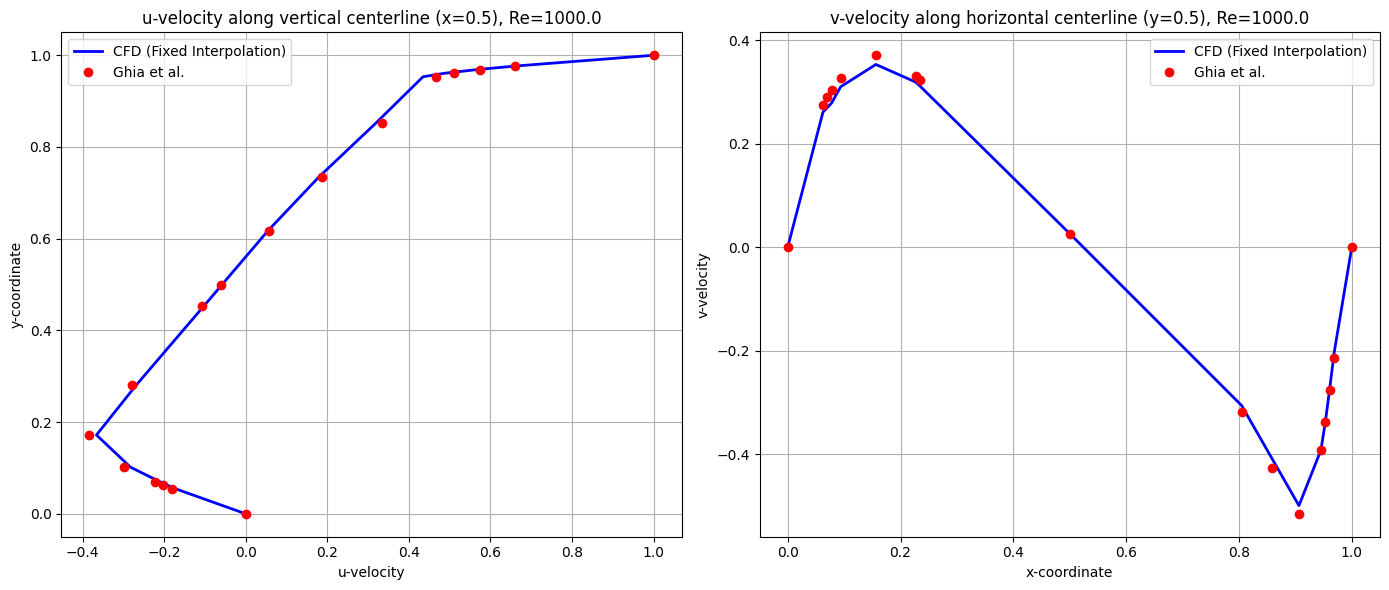

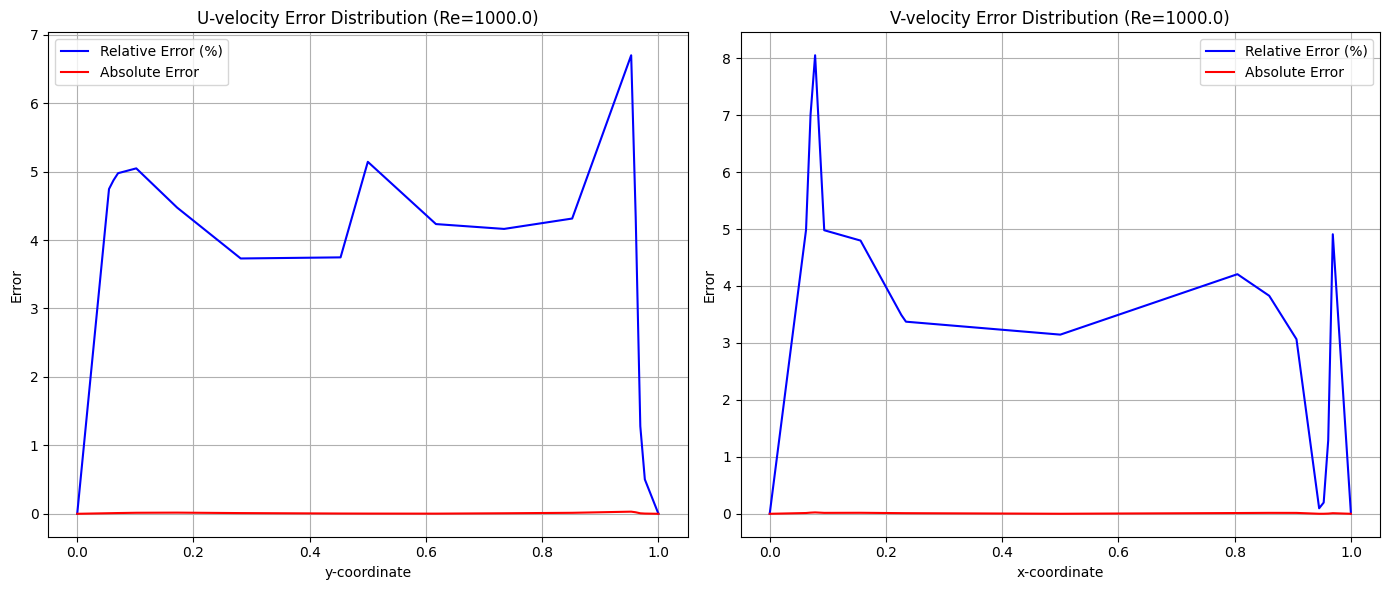

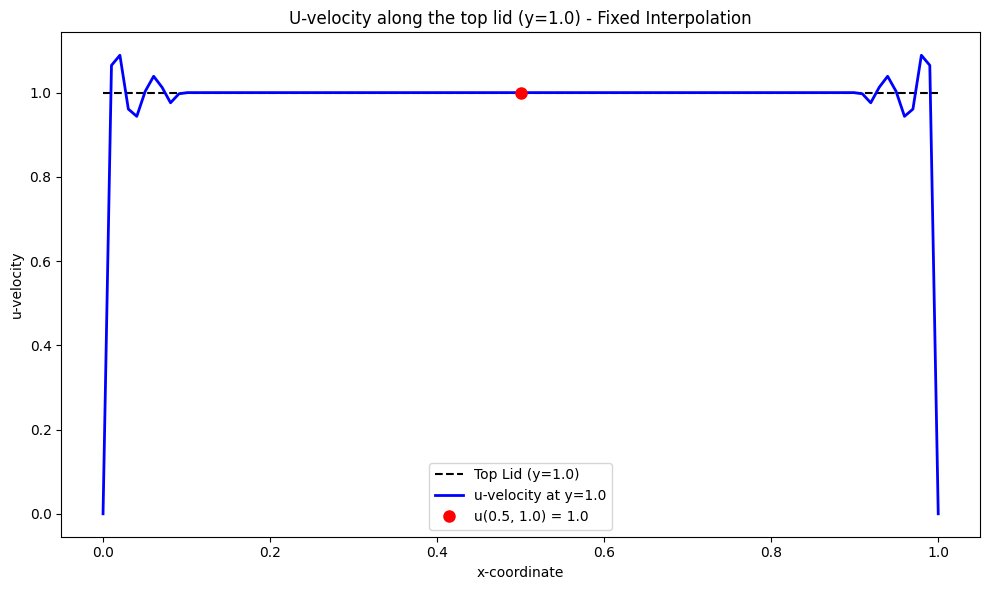

(array([ 1.        ,  0.66259244,  0.56756241,  0.48904677,  0.43481917,
         0.31867367,  0.17939918,  0.05460645, -0.0576735 , -0.10249087,
        -0.26767816, -0.36576116, -0.28229633, -0.21114276, -0.19211668,
        -0.17249714,  0.        ]),
 array([ 0.        ,  0.26115023,  0.26977303,  0.27909423,  0.31002657,
         0.35315679,  0.31921266,  0.31147741,  0.0260546 , -0.3062122 ,
        -0.41031871, -0.49969766, -0.39225815, -0.33780467, -0.27312101,
        -0.2033827 ,  0.        ]),
 array([0.        , 0.00331244, 0.00735759, 0.02212323, 0.03122083,
        0.01436633, 0.00779082, 0.00241355, 0.0031265 , 0.00398913,
        0.01037184, 0.01712884, 0.01500367, 0.01105724, 0.00984332,
        0.00859286, 0.        ]),
 array([0.        , 0.01369977, 0.02034697, 0.02443577, 0.01624343,
        0.01779321, 0.01153734, 0.01087259, 0.0007946 , 0.0134478 ,
        0.01633129, 0.01580234, 0.00037815, 0.00066467, 0.00356899,
        0.0104973 , 0.        ]),
 array([0.    

In [11]:
def fixed_detailed_ghia_error_distribution(xp, yp, u, v, nelem, nterm, Re=100):
    """
    Detailed analysis of how CFD results compare to Ghia et al. (1982) benchmark.
    This fixed version uses the corrected interpolation approach that preserves the
    u-velocity at the north boundary (y=1.0) when x=0.5.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    u, v : arrays
        Velocity components at each collocation point
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    Re : int
        Reynolds number to select appropriate Ghia benchmark data
        Options: 100, 400, 1000, 3200, 10000
    """
    # Ghia et al. data selection based on Reynolds number
    if Re not in ghia_data:
        print(f"Reynolds number {Re} not available. Choose from: {list(ghia_data.keys())}")
        return
    
    ghia = ghia_data[Re]
    
    # Generate GLL points for interpolation
    gll_points, _ = legendre_gauss_lobatto_points(nterm)
    
    # Create a function for spectral element interpolation at a specific point
    def spectral_interp_at_point(x_target, y_target):
        """Perform spectral element interpolation at a specific point using GLL basis functions"""
        # Find which element contains the target point
        containing_element = None
        for ne in range(nelem):
            x_min, x_max = np.min(xp[:, ne]), np.max(xp[:, ne])
            y_min, y_max = np.min(yp[:, ne]), np.max(yp[:, ne])
            
            if (x_min <= x_target <= x_max) and (y_min <= y_target <= y_max):
                containing_element = ne
                break
        
        if containing_element is None:
            # Point is outside the domain
            return np.nan, np.nan
        
        ne = containing_element
        
        # Map physical point to reference domain [-1, 1]×[-1, 1]
        x_min, x_max = np.min(xp[:, ne]), np.max(xp[:, ne])
        y_min, y_max = np.min(yp[:, ne]), np.max(yp[:, ne])
        
        xi = 2 * (x_target - x_min) / (x_max - x_min) - 1
        eta = 2 * (y_target - y_min) / (y_max - y_min) - 1
        
        # Evaluate all basis functions at the mapped point
        L_xi = np.zeros(nterm)
        L_eta = np.zeros(nterm)
        
        for j in range(nterm):
            # Compute Lagrange basis function values
            l_xi_j = 1.0
            l_eta_j = 1.0
            
            for k in range(nterm):
                if k != j:
                    l_xi_j *= (xi - gll_points[k]) / (gll_points[j] - gll_points[k])
                    l_eta_j *= (eta - gll_points[k]) / (gll_points[j] - gll_points[k])
                    
            L_xi[j] = l_xi_j
            L_eta[j] = l_eta_j
        
        # Interpolate velocity components
        u_interp = 0.0
        v_interp = 0.0
        
        for i in range(nterm):
            for j in range(nterm):
                # Tensor product of basis functions
                basis_val = L_xi[i] * L_eta[j]
                
                # Add contribution from this GLL node
                u_interp += u[i, j, ne] * basis_val
                v_interp += v[i, j, ne] * basis_val
        
        return u_interp, v_interp
    
    # Interpolate at the Ghia comparison points
    # For u(x=0.5, y) profile
    u_cfd_at_ghia = np.zeros_like(ghia['y'])
    for i, y_val in enumerate(ghia['y']):
        u_val, _ = spectral_interp_at_point(0.5, y_val)
        u_cfd_at_ghia[i] = u_val
    
    # For v(x, y=0.5) profile
    v_cfd_at_ghia = np.zeros_like(ghia['x'])
    for i, x_val in enumerate(ghia['x']):
        _, v_val = spectral_interp_at_point(x_val, 0.5)
        v_cfd_at_ghia[i] = v_val
    
    # Calculate error metrics
    u_abs_error = np.abs(u_cfd_at_ghia - ghia['u'])
    v_abs_error = np.abs(v_cfd_at_ghia - ghia['v'])
    u_rel_error = 100 * u_abs_error / np.maximum(1e-6, np.abs(ghia['u']))  # as percentage
    v_rel_error = 100 * v_abs_error / np.maximum(1e-6, np.abs(ghia['v']))  # as percentage
    
    # Replace infinity values (division by zero) with NaN
    u_rel_error[np.isinf(u_rel_error) | np.isnan(u_rel_error)] = np.nan
    v_rel_error[np.isinf(v_rel_error) | np.isnan(v_rel_error)] = np.nan
    
    # Calculate overall error metrics
    u_rmse = np.sqrt(np.mean((u_cfd_at_ghia - ghia['u'])**2))
    v_rmse = np.sqrt(np.mean((v_cfd_at_ghia - ghia['v'])**2))
    u_max_error = np.max(u_abs_error)
    v_max_error = np.max(v_abs_error)
    
    print(f"\n--- Comparison with Ghia's Data (Re={Re}) - Fixed Interpolation ---")
    print(f"U-velocity RMSE: {u_rmse:.6f}")
    print(f"V-velocity RMSE: {v_rmse:.6f}")
    print(f"U-velocity maximum absolute error: {u_max_error:.6f}")
    print(f"V-velocity maximum absolute error: {v_max_error:.6f}")
    
    # Plot velocity comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # U-velocity comparison
    ax1.plot(u_cfd_at_ghia, ghia['y'], 'b-', linewidth=2, label='CFD (Fixed Interpolation)')
    ax1.plot(ghia['u'], ghia['y'], 'ro', markersize=6, label='Ghia et al.')
    ax1.set_xlabel('u-velocity')
    ax1.set_ylabel('y-coordinate')
    ax1.set_title(f'u-velocity along vertical centerline (x=0.5), Re={Re}')
    ax1.grid(True)
    ax1.legend()
    
    # V-velocity comparison
    ax2.plot(ghia['x'], v_cfd_at_ghia, 'b-', linewidth=2, label='CFD (Fixed Interpolation)')
    ax2.plot(ghia['x'], ghia['v'], 'ro', markersize=6, label='Ghia et al.')
    ax2.set_xlabel('x-coordinate')
    ax2.set_ylabel('v-velocity')
    ax2.set_title(f'v-velocity along horizontal centerline (y=0.5), Re={Re}')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Error distribution plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Error distribution for u-velocity
    ax1.plot(ghia['y'], u_rel_error, 'b-', label='Relative Error (%)')
    ax1.plot(ghia['y'], u_abs_error, 'r-', label='Absolute Error')
    ax1.set_xlabel('y-coordinate')
    ax1.set_ylabel('Error')
    ax1.set_title(f'U-velocity Error Distribution (Re={Re})')
    ax1.legend()
    ax1.grid(True)
    
    # Error distribution for v-velocity
    ax2.plot(ghia['x'], v_rel_error, 'b-', label='Relative Error (%)')
    ax2.plot(ghia['x'], v_abs_error, 'r-', label='Absolute Error')
    ax2.set_xlabel('x-coordinate')
    ax2.set_ylabel('Error')
    ax2.set_title(f'V-velocity Error Distribution (Re={Re})')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Focus on the north boundary u-velocity (y=1.0)
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [1, 1], 'k--', label='Top Lid (y=1.0)')
    
    # Extract u-velocities at y=1.0 for different x values
    x_values = np.linspace(0, 1, 100)
    u_at_top = np.zeros_like(x_values)
    for i, x_val in enumerate(x_values):
        u_val, _ = spectral_interp_at_point(x_val, 1.0)
        u_at_top[i] = u_val
    
    plt.plot(x_values, u_at_top, 'b-', linewidth=2, label='u-velocity at y=1.0')
    
    # Highlight u=1.0 at x=0.5
    plt.plot(0.5, 1.0, 'ro', markersize=8, label='u(0.5, 1.0) = 1.0')
    
    plt.xlabel('x-coordinate')
    plt.ylabel('u-velocity')
    plt.title('U-velocity along the top lid (y=1.0) - Fixed Interpolation')
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return u_cfd_at_ghia, v_cfd_at_ghia, u_abs_error, v_abs_error, u_rel_error, v_rel_error

# Example usage with current Reynolds number
fixed_detailed_ghia_error_distribution(xp, yp, u, v, nelem, nterm, re)

## Wall Shear Stress Analysis
This section calculates the wall shear stress along the four walls of the cavity and identifies locations where the shear stress crosses zero. These zero crossing points are important in flow analysis as they often indicate flow separation or reattachment points, as well as the centers of recirculation regions adjacent to the walls.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def lgl_points_weights(N):
    """Generate Legendre-Gauss-Lobatto points and weights"""
    if N == 0:
        return np.array([0.0]), np.array([2.0])
    elif N == 1:
        return np.array([-1.0, 1.0]), np.array([1.0, 1.0])
    
    # For N > 1, use iterative method
    x = np.zeros(N+1)
    x[0] = -1.0
    x[N] = 1.0
    
    if N >= 2:
        # Interior points - better initial guess
        for i in range(1, N):
            x[i] = -np.cos((2*i - 1) * np.pi / (2*N))
        
        # Newton-Raphson refinement
        for i in range(1, N):
            for iter in range(20):
                P, Pp = legendre_poly_deriv(x[i], N)
                if abs(Pp) > 1e-15:
                    dx = -P / Pp
                    x[i] += dx
                    if abs(dx) < 1e-15:
                        break
    
    # Sort points
    x = np.sort(x)
    
    # Compute weights
    w = np.zeros(N+1)
    for i in range(N+1):
        P, _ = legendre_poly_deriv(x[i], N)
        w[i] = 2.0 / (N * (N+1) * P**2)
    
    return x, w

def legendre_poly_deriv(x, N):
    """Compute Legendre polynomial and its derivative at x"""
    if N == 0:
        return 1.0, 0.0
    elif N == 1:
        return x, 1.0
    
    P0, P1 = 1.0, x
    Pp0, Pp1 = 0.0, 1.0
    
    for n in range(2, N+1):
        P2 = ((2*n-1)*x*P1 - (n-1)*P0) / n
        Pp2 = ((2*n-1)*(x*Pp1 + P1) - (n-1)*Pp0) / n
        P0, P1 = P1, P2
        Pp0, Pp1 = Pp1, Pp2
    
    return P1, Pp1

def compute_derivative_matrix(x):
    """Compute the derivative matrix for LGL points"""
    N = len(x) - 1
    D = np.zeros((N+1, N+1))
    
    for i in range(N+1):
        for j in range(N+1):
            if i != j:
                Pi, _ = legendre_poly_deriv(x[i], N)
                Pj, _ = legendre_poly_deriv(x[j], N)
                if abs(x[i] - x[j]) > 1e-15:
                    D[i, j] = (Pi / Pj) / (x[i] - x[j])
            else:
                if i == 0:
                    D[i, i] = -N * (N+1) / 4.0
                elif i == N:
                    D[i, i] = N * (N+1) / 4.0
                else:
                    D[i, i] = 0.0
    
    return D

def calculate_wall_shear_stress_lgl(u, v, xp, yp, nelem, nterm):
    """
    Calculate wall shear stress using LGL derivative matrix
    
    Note: The coordinate data structure suggests that xp and yp contain
    unique coordinates that form the spectral element grid.
    """
    print(f"Data shapes: u={u.shape}, v={v.shape}, xp={xp.shape}, yp={yp.shape}")
    print(f"Number of elements: {nelem}, Terms per element: {nterm}")
    
    # nterm is the number of points in each direction
    Np = nterm
    N = Np - 1  # Polynomial order
    
    print(f"Points per direction: {Np}, Polynomial order N = {N}")
    
    # Generate LGL points and derivative matrix
    xi, _ = lgl_points_weights(N)
    D = compute_derivative_matrix(xi)
    
    print(f"LGL points: {xi}")
    print(f"Derivative matrix shape: {D.shape}")
    
    # Initialize wall shear stress data
    wall_shear_data = {
        'bottom': {'x': [], 'y': [], 'tau': []},
        'top': {'x': [], 'y': [], 'tau': []},
        'left': {'x': [], 'y': [], 'tau': []},
        'right': {'x': [], 'y': [], 'tau': []}
    }
    
    # Reynolds number for viscous scaling
    Re = 1000.0
    
    # Debug: Check coordinate structure for first few elements
    print(f"\\nCoordinate analysis:")
    for ne in range(min(3, nelem)):
        print(f"Element {ne}: x={xp[:, ne]}, y={yp[:, ne]}")
    
    # Loop through elements
    for ne in range(nelem):
        # Extract solution for this element - already in 2D grid format
        u_elem = u[:, :, ne]  # Shape (Np, Np)
        v_elem = v[:, :, ne]  # Shape (Np, Np)
        
        # For SEM, the coordinates stored in xp[:, ne] and yp[:, ne] 
        # typically represent the physical coordinates of the LGL points
        # Since we have nterm points, they likely correspond to a tensor product grid
        
        # Let's assume the coordinates are stored in a standard way:
        # If we have a 2D element, we need to figure out how to map the 1D coordinate
        # arrays to the 2D tensor product grid
        
        x_coords = xp[:, ne]
        y_coords = yp[:, ne]
        
        # Check if coordinates form a simple tensor product
        # Extract unique x and y values
        x_unique = np.unique(x_coords)
        y_unique = np.unique(y_coords)
        
        if len(x_unique) == Np and len(y_unique) == 1:
            # This element varies only in x (horizontal strip)
            x_elem = np.tile(x_coords, (Np, 1))  # Repeat x for each y
            y_elem = np.tile(y_coords[0], (Np, Np))  # Constant y
        elif len(y_unique) == Np and len(x_unique) == 1:
            # This element varies only in y (vertical strip)
            x_elem = np.tile(x_coords[0], (Np, Np))  # Constant x
            y_elem = np.tile(y_coords, (1, Np)).T  # Repeat y for each x
        else:
            # General case: try to reconstruct from the coordinate arrays
            # Assume the coordinates represent corner and edge points
            x_min, x_max = np.min(x_coords), np.max(x_coords)
            y_min, y_max = np.min(y_coords), np.max(y_coords)
            
            # Create tensor product grid using LGL points mapped to element
            xi_mapped = 0.5 * ((x_max - x_min) * xi + (x_max + x_min))
            eta_mapped = 0.5 * ((y_max - y_min) * xi + (y_max + y_min))
            
            x_elem, y_elem = np.meshgrid(xi_mapped, eta_mapped, indexing='ij')
        
        # Check if this element is on a boundary
        x_min, x_max = np.min(x_elem), np.max(x_elem)
        y_min, y_max = np.min(y_elem), np.max(y_elem)
        
        if ne < 3:  # Debug for first few elements
            print(f"Element {ne}: x_range=({x_min:.6f}, {x_max:.6f}), y_range=({y_min:.6f}, {y_max:.6f})")
        
        # Bottom wall (y ≈ 0)
        if abs(y_min) < 1e-6:
            j = 0  # Bottom edge
            for i in range(Np):
                x_wall = x_elem[i, j]
                y_wall = y_elem[i, j]
                
                # Compute du/dy at the wall using derivative matrix
                # Need to transform derivative from computational to physical space
                
                # In computational space: du/dη
                du_deta = np.sum(D[j, :] * u_elem[i, :])
                
                # Jacobian transformation: dy/dη
                dy_deta = np.sum(D[j, :] * y_elem[i, :])
                
                # Physical space derivative: du/dy = (du/dη) / (dy/dη)
                if abs(dy_deta) > 1e-12:
                    du_dy = du_deta / dy_deta
                    # Wall shear stress: τ = μ * du/dy = (1/Re) * du/dy
                    tau_wall = du_dy / Re
                else:
                    tau_wall = 0.0
                
                # Limit extreme values (numerical issues)
                if abs(tau_wall) < 1e6:  # Reasonable physical limit
                    wall_shear_data['bottom']['x'].append(x_wall)
                    wall_shear_data['bottom']['y'].append(y_wall)
                    wall_shear_data['bottom']['tau'].append(tau_wall)
        
        # Top wall (y ≈ 1)
        if abs(y_max - 1.0) < 1e-6:
            j = N  # Top edge
            for i in range(Np):
                x_wall = x_elem[i, j]
                y_wall = y_elem[i, j]
                
                du_deta = np.sum(D[j, :] * u_elem[i, :])
                dy_deta = np.sum(D[j, :] * y_elem[i, :])
                
                if abs(dy_deta) > 1e-12:
                    du_dy = du_deta / dy_deta
                    tau_wall = du_dy / Re
                    if abs(tau_wall) < 1e6:
                        wall_shear_data['top']['x'].append(x_wall)
                        wall_shear_data['top']['y'].append(y_wall)
                        wall_shear_data['top']['tau'].append(tau_wall)
        
        # Left wall (x ≈ 0)
        if abs(x_min) < 1e-6:
            i = 0  # Left edge
            for j in range(Np):
                x_wall = x_elem[i, j]
                y_wall = y_elem[i, j]
                
                # Compute dv/dx at the wall
                dv_dxi = np.sum(D[i, :] * v_elem[:, j])
                dx_dxi = np.sum(D[i, :] * x_elem[:, j])
                
                if abs(dx_dxi) > 1e-12:
                    dv_dx = dv_dxi / dx_dxi
                    tau_wall = dv_dx / Re
                    if abs(tau_wall) < 1e6:
                        wall_shear_data['left']['x'].append(x_wall)
                        wall_shear_data['left']['y'].append(y_wall)
                        wall_shear_data['left']['tau'].append(tau_wall)
        
        # Right wall (x ≈ 1)
        if abs(x_max - 1.0) < 1e-6:
            i = N  # Right edge
            for j in range(Np):
                x_wall = x_elem[i, j]
                y_wall = y_elem[i, j]
                
                dv_dxi = np.sum(D[i, :] * v_elem[:, j])
                dx_dxi = np.sum(D[i, :] * x_elem[:, j])
                
                if abs(dx_dxi) > 1e-12:
                    dv_dx = dv_dxi / dx_dxi
                    tau_wall = dv_dx / Re
                    if abs(tau_wall) < 1e6:
                        wall_shear_data['right']['x'].append(x_wall)
                        wall_shear_data['right']['y'].append(y_wall)
                        wall_shear_data['right']['tau'].append(tau_wall)
    
    # Convert lists to arrays and sort by position
    for wall in wall_shear_data:
        if wall_shear_data[wall]['x']:
            x_arr = np.array(wall_shear_data[wall]['x'])
            y_arr = np.array(wall_shear_data[wall]['y'])
            tau_arr = np.array(wall_shear_data[wall]['tau'])
            
            if wall in ['bottom', 'top']:
                sort_idx = np.argsort(x_arr)
            else:
                sort_idx = np.argsort(y_arr)
            
            wall_shear_data[wall]['x'] = x_arr[sort_idx]
            wall_shear_data[wall]['y'] = y_arr[sort_idx]
            wall_shear_data[wall]['tau'] = tau_arr[sort_idx]
    
    return wall_shear_data

print("LGL-based wall shear stress functions defined successfully!")
print(f"Available variables: nelem={nelem}, nterm={nterm}")
print(f"Solution arrays - u: {u.shape}, v: {v.shape}")
print(f"Coordinates - xp: {xp.shape}, yp: {yp.shape}")

LGL-based wall shear stress functions defined successfully!
Available variables: nelem=36, nterm=7
Solution arrays - u: (7, 7, 36), v: (7, 7, 36)
Coordinates - xp: (7, 36), yp: (7, 36)


In [13]:
# Calculate wall shear stress using LGL derivative matrix
print("Calculating wall shear stress using LGL derivatives...")

# Use the LGL-based function
wall_shear_data = calculate_wall_shear_stress_lgl(u, v, xp, yp, nelem, nterm)

print("Wall shear stress calculation completed!")
print(f"Bottom wall points: {len(wall_shear_data['bottom']['x'])}")
print(f"Top wall points: {len(wall_shear_data['top']['x'])}")
print(f"Left wall points: {len(wall_shear_data['left']['x'])}")
print(f"Right wall points: {len(wall_shear_data['right']['x'])}")

# Show some sample values
if len(wall_shear_data['bottom']['x']) > 0:
    print(f"Bottom wall shear stress range: {np.min(wall_shear_data['bottom']['tau']):.6f} to {np.max(wall_shear_data['bottom']['tau']):.6f}")
if len(wall_shear_data['top']['x']) > 0:
    print(f"Top wall shear stress range: {np.min(wall_shear_data['top']['tau']):.6f} to {np.max(wall_shear_data['top']['tau']):.6f}")

Calculating wall shear stress using LGL derivatives...
Data shapes: u=(7, 7, 36), v=(7, 7, 36), xp=(7, 36), yp=(7, 36)
Number of elements: 36, Terms per element: 7
Points per direction: 7, Polynomial order N = 6
LGL points: [-1.         -0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939
  1.        ]
Derivative matrix shape: (7, 7)
\nCoordinate analysis:
Element 0: x=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 1: x=[0.1      0.108489 0.126558 0.15     0.173442 0.191511 0.2     ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 2: x=[0.2      0.225466 0.279673 0.35     0.420327 0.474534 0.5     ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 0: x_range=(0.000000, 0.100000), y_range=(0.000000, 0.100000)
Element 1: x_range=(0.100000, 0.200000), y_range=(0.000000, 0.100000)


Data shapes: u=(7, 7, 36), v=(7, 7, 36), xp=(7, 36), yp=(7, 36)
Number of elements: 36, Terms per element: 7
Points per direction: 7, Polynomial order N = 6
LGL points: [-1.         -0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939
  1.        ]
Derivative matrix shape: (7, 7)
\nCoordinate analysis:
Element 0: x=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 1: x=[0.1      0.108489 0.126558 0.15     0.173442 0.191511 0.2     ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 2: x=[0.2      0.225466 0.279673 0.35     0.420327 0.474534 0.5     ], y=[0.         0.00848881 0.0265576  0.05       0.0734424  0.0915112
 0.1       ]
Element 0: x_range=(0.000000, 0.100000), y_range=(0.000000, 0.100000)
Element 1: x_range=(0.100000, 0.200000), y_range=(0.000000, 0.100000)
Element 2: x_range=(0.200000, 0.500000), y_range=(0.000

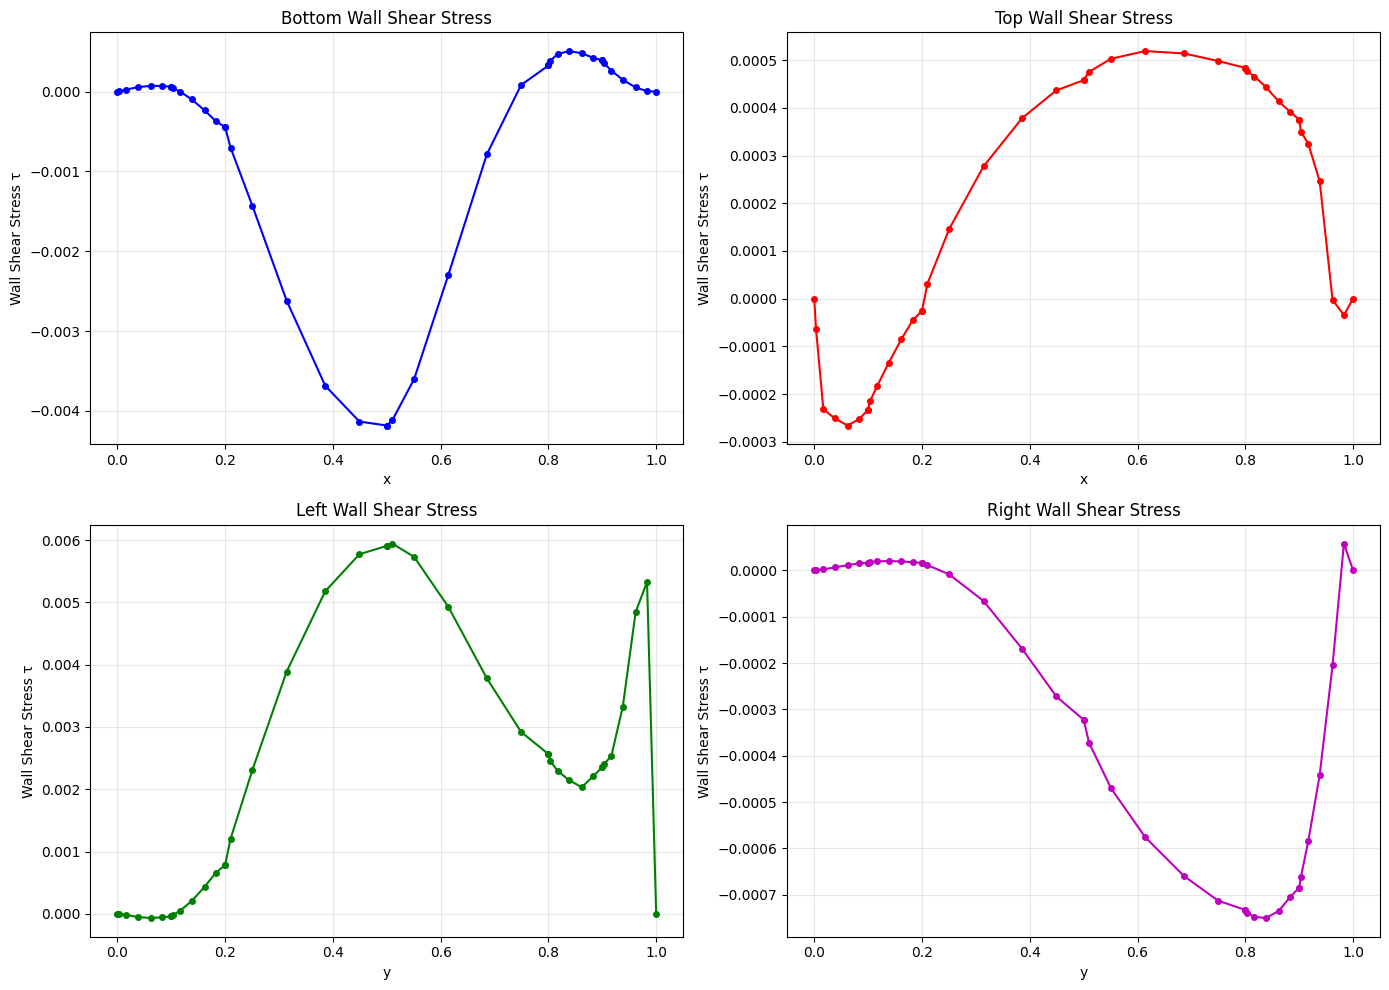

In [14]:
# Calculate and visualize wall shear stress using LGL derivatives
wall_shear = calculate_wall_shear_stress_lgl(u, v, xp, yp, nelem, nterm)

# Additional analysis of results
print("\nSummary of wall shear stress results:")

for wall_name in ['bottom', 'top', 'left', 'right']:
    if len(wall_shear[wall_name]['x']) > 0:
        tau_values = wall_shear[wall_name]['tau']
        print(f"{wall_name.capitalize()} wall:")
        print(f"  Points: {len(tau_values)}")
        print(f"  Min τ: {np.min(tau_values):.6f}")
        print(f"  Max τ: {np.max(tau_values):.6f}")
        print(f"  Mean τ: {np.mean(tau_values):.6f}")
        
        # Find points with near-zero shear stress
        zero_indices = np.where(np.abs(tau_values) < 1e-6)[0]
        if len(zero_indices) > 0:
            print(f"  Near-zero shear points: {len(zero_indices)}")
        print()

# Plot wall shear stress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Bottom wall
if len(wall_shear['bottom']['x']) > 0:
    ax1.plot(wall_shear['bottom']['x'], wall_shear['bottom']['tau'], 'b-o', markersize=4)
    ax1.set_xlabel('x')
    ax1.set_ylabel('Wall Shear Stress τ')
    ax1.set_title('Bottom Wall Shear Stress')
    ax1.grid(True, alpha=0.3)

# Top wall  
if len(wall_shear['top']['x']) > 0:
    ax2.plot(wall_shear['top']['x'], wall_shear['top']['tau'], 'r-o', markersize=4)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Wall Shear Stress τ')
    ax2.set_title('Top Wall Shear Stress')
    ax2.grid(True, alpha=0.3)

# Left wall
if len(wall_shear['left']['y']) > 0:
    ax3.plot(wall_shear['left']['y'], wall_shear['left']['tau'], 'g-o', markersize=4)
    ax3.set_xlabel('y')
    ax3.set_ylabel('Wall Shear Stress τ')
    ax3.set_title('Left Wall Shear Stress')
    ax3.grid(True, alpha=0.3)

# Right wall
if len(wall_shear['right']['y']) > 0:
    ax4.plot(wall_shear['right']['y'], wall_shear['right']['tau'], 'm-o', markersize=4)
    ax4.set_xlabel('y')
    ax4.set_ylabel('Wall Shear Stress τ')
    ax4.set_title('Right Wall Shear Stress')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Create an optimized interpolation function with caching
@lru_cache(maxsize=64)
def cached_interpolate(ne, n_grid, interp_method='cubic'):
    """
    Perform cached interpolation for an element to avoid redundant calculations.
    
    Parameters:
    -----------
    ne : int
        Element number
    n_grid : int
        Size of uniform grid for interpolation (n_grid x n_grid)
    interp_method : str
        Interpolation method ('linear', 'cubic', 'nearest')
        
    Returns:
    --------
    tuple
        (X_grid, Y_grid, U_grid, V_grid, P_grid, bounds)
    """
    # Get element bounds
    x_min, x_max = np.min(xp[:, ne]), np.max(xp[:, ne])
    y_min, y_max = np.min(yp[:, ne]), np.max(yp[:, ne])
    
    # Create uniform grid for this element
    x_lin = np.linspace(x_min, x_max, n_grid)
    y_lin = np.linspace(y_min, y_max, n_grid)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='xy')
    
    # Prepare points for interpolation
    points = []
    values_u = []
    values_v = []
    values_p = []
    
    # Gather points and values for this element
    for i in range(nterm):
        for j in range(nterm):
            x_point = xp[i, ne]
            y_point = yp[j, ne]
            points.append([x_point, y_point])
            values_u.append(u[i, j, ne])
            values_v.append(v[i, j, ne])
            values_p.append(p[i, j, ne])
    
    # Convert to numpy arrays for faster processing
    points = np.array(points)
    values_u = np.array(values_u)
    values_v = np.array(values_v)
    values_p = np.array(values_p)
    
    # Reshape the grid for interpolation
    grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    
    # Choose method based on number of points
    if interp_method == 'cubic' and nterm <= 3:
        interp_method = 'linear'
    
    # Interpolate fields to the uniform grid
    U_grid = griddata(points, values_u, grid_points, method=interp_method)
    V_grid = griddata(points, values_v, grid_points, method=interp_method)
    P_grid = griddata(points, values_p, grid_points, method=interp_method)
    
    # Reshape back to grid format
    U_grid = U_grid.reshape(X_grid.shape)
    V_grid = V_grid.reshape(X_grid.shape)
    P_grid = P_grid.reshape(X_grid.shape)
    
    bounds = [x_min, x_max, y_min, y_max]
    
    return X_grid, Y_grid, U_grid, V_grid, P_grid, bounds

In [16]:
def plot_optimized_contours(xp, yp, u, v, p, nelem, nterm, re, field='pressure', n_grid=100):
    """
    Plot optimized contours of velocity or pressure fields with enhanced hover coordinate display.
    
    Parameters:
    -----------
    xp, yp : arrays
        Collocation point coordinates for each element
    u, v : arrays
        Velocity components at each collocation point
    p : array
        Pressure values at each collocation point
    nelem : int
        Number of elements
    nterm : int
        Number of collocation points per element dimension
    re : float
        Reynolds number of the simulation
    field : str
        Field to plot ('pressure', 'u-velocity', 'v-velocity', 'speed')
    n_grid : int
        Size of uniform grid for interpolation
    """
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Determine global domain bounds
    x_min_global, x_max_global = np.min(xp), np.max(xp)
    y_min_global, y_max_global = np.min(yp), np.max(yp)
    
    # Create global uniform grid
    x_global = np.linspace(x_min_global, x_max_global, n_grid)
    y_global = np.linspace(y_min_global, y_max_global, n_grid)
    X_global, Y_global = np.meshgrid(x_global, y_global, indexing='xy')
    
    # Initialize arrays for interpolated data
    U_global = np.zeros_like(X_global) * np.nan
    V_global = np.zeros_like(X_global) * np.nan
    P_global = np.zeros_like(X_global) * np.nan
    mask_global = np.zeros_like(X_global, dtype=bool)
    
    # Process each element and map to global grid
    for ne in range(nelem):
        # Get interpolated data for this element
        X_elem, Y_elem, U_elem, V_elem, P_elem, bounds = cached_interpolate(ne, n_grid//2)
        x_min, x_max, y_min, y_max = bounds
        
        # Find indices in global grid corresponding to this element
        x_indices = np.logical_and(X_global >= x_min, X_global <= x_max)
        y_indices = np.logical_and(Y_global >= y_min, Y_global <= y_max)
        elem_mask = np.logical_and(x_indices, y_indices)
        
        # Update mask for this element
        mask_global = np.logical_or(mask_global, elem_mask)
        
        # For each point in global grid within this element, interpolate from element grid
        elem_points = np.column_stack((X_global[elem_mask].ravel(), Y_global[elem_mask].ravel()))
        
        if len(elem_points) > 0:
            # Reshape element grid for interpolation
            elem_X_pts = X_elem.ravel()
            elem_Y_pts = Y_elem.ravel()
            elem_U_vals = U_elem.ravel()
            elem_V_vals = V_elem.ravel()
            elem_P_vals = P_elem.ravel()
            
            # Create grid points and values for this element
            elem_grid_pts = np.column_stack((elem_X_pts, elem_Y_pts))
            
            # Find points inside this element
            for idx, (xi, yi) in enumerate(elem_points):
                # Find the closest index in the element grid
                dist = (elem_X_pts - xi)**2 + (elem_Y_pts - yi)**2
                closest_idx = np.argmin(dist)
                
                # Get flat index in global grid
                global_idx = np.where(np.logical_and(X_global == xi, Y_global == yi))
                if len(global_idx[0]) > 0 and len(global_idx[1]) > 0:
                    i, j = global_idx[0][0], global_idx[1][0]
                    U_global[i, j] = elem_U_vals[closest_idx]
                    V_global[i, j] = elem_V_vals[closest_idx]
                    P_global[i, j] = elem_P_vals[closest_idx]
    
    # Apply mask to data
    U_masked = np.ma.masked_array(U_global, ~mask_global)
    V_masked = np.ma.masked_array(V_global, ~mask_global)
    P_masked = np.ma.masked_array(P_global, ~mask_global)
    speed = np.sqrt(U_masked**2 + V_masked**2)
    
    # Determine what to plot based on field parameter
    if field == 'pressure':
        data = P_masked
        title = f'Pressure Contours (Re = {re:.1f})'
        cmap = plt.cm.coolwarm
        label = 'Pressure'
    elif field == 'u-velocity':
        data = U_masked
        title = f'U-Velocity Contours (Re = {re:.1f})'
        cmap = plt.cm.viridis
        label = 'U-Velocity'
    elif field == 'v-velocity':
        data = V_masked
        title = f'V-Velocity Contours (Re = {re:.1f})'
        cmap = plt.cm.viridis
        label = 'V-Velocity'
    elif field == 'speed':
        data = speed
        title = f'Velocity Magnitude Contours (Re = {re:.1f})'
        cmap = plt.cm.plasma
        label = 'Speed'
    else:
        raise ValueError(f"Unknown field: {field}")
    
    # Plot contours
    contour = ax.contourf(X_global, Y_global, data, levels=20, cmap=cmap)
    cbar = plt.colorbar(contour, ax=ax, label=label)
    
    # Add element boundaries (optional, commented out for cleaner plot)
    # for ne in range(nelem):
    #     x_min, x_max = np.min(xp[:, ne]), np.max(xp[:, ne])
    #     y_min, y_max = np.min(yp[:, ne]), np.max(yp[:, ne])
    #     ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 
    #             'k-', linewidth=0.5, alpha=0.3)
    
    # Add axes labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.set_aspect('equal')
    
    # Add enhanced coordinate readout
    add_coordinate_readout(fig, ax)
    
    # Add annotation to show data value at hover location
    hover_value_text = fig.text(0.99, 0.97, "", va="top", ha="right",
                         bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.8))
    
    # Enhanced hover function to show data value
    def on_hover(event):
        if event.inaxes == ax:
            x, y = event.xdata, event.ydata
            # Find nearest grid point
            i = np.argmin(np.abs(y_global - y))
            j = np.argmin(np.abs(x_global - x))
            
            if mask_global[i, j]:
                value = data[i, j]
                hover_value_text.set_text(f"{label}: {value:.6f}")
            else:
                hover_value_text.set_text(f"{label}: N/A")
                
            # Update every few events to improve performance
            if getattr(on_hover, 'counter', 0) % 5 == 0:
                fig.canvas.draw_idle()
            on_hover.counter = getattr(on_hover, 'counter', 0) + 1
    
    # Connect hover event
    fig.canvas.mpl_connect('motion_notify_event', on_hover)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

## Optimized Plotting with Enhanced Hover Coordinate Display
The following cells demonstrate the optimized plotting functions with enhanced hover coordinate display. When you hover over the plot, you'll see the coordinates and data value in real-time.

/var/folders/49/537_h6nd37740hj1p096c30w0000gn/T/ipykernel_2237/2476609931.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


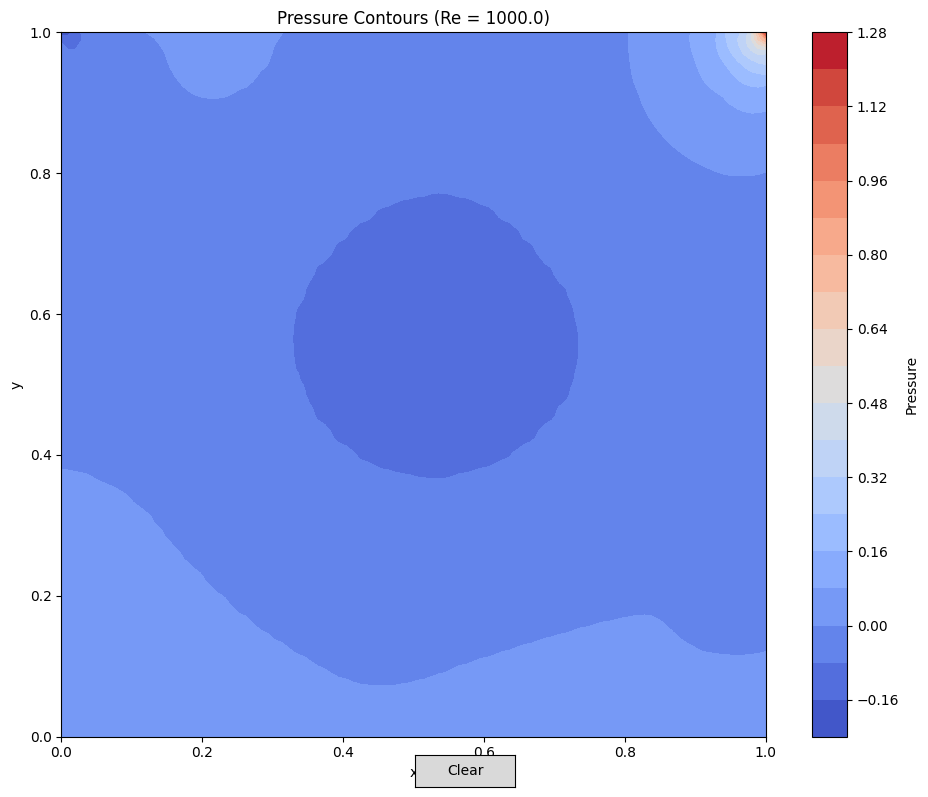

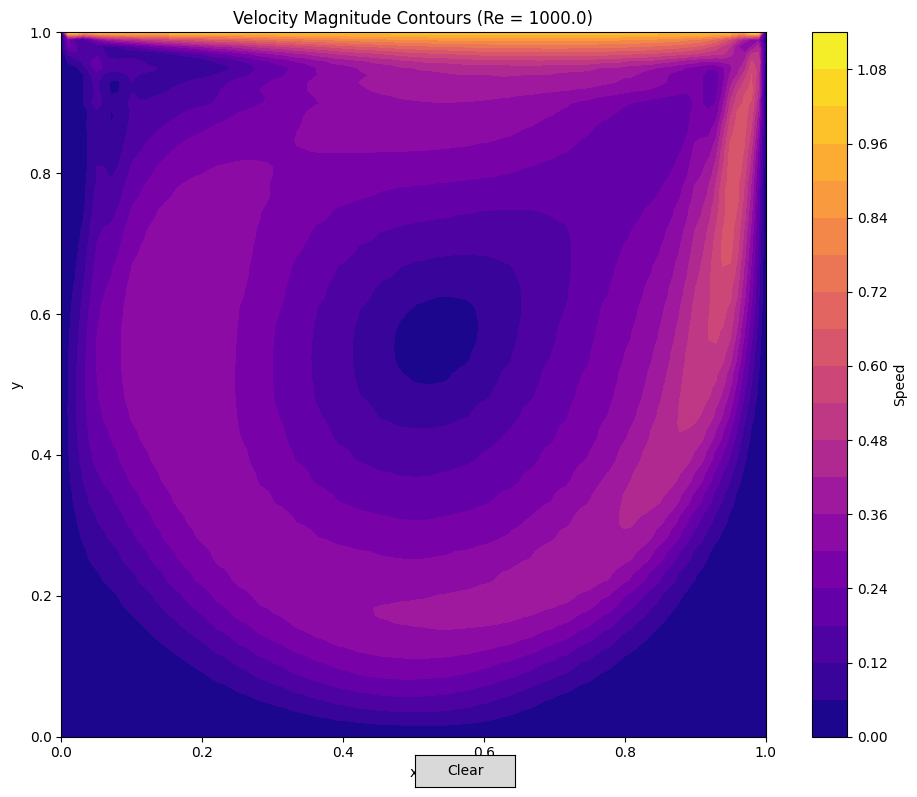

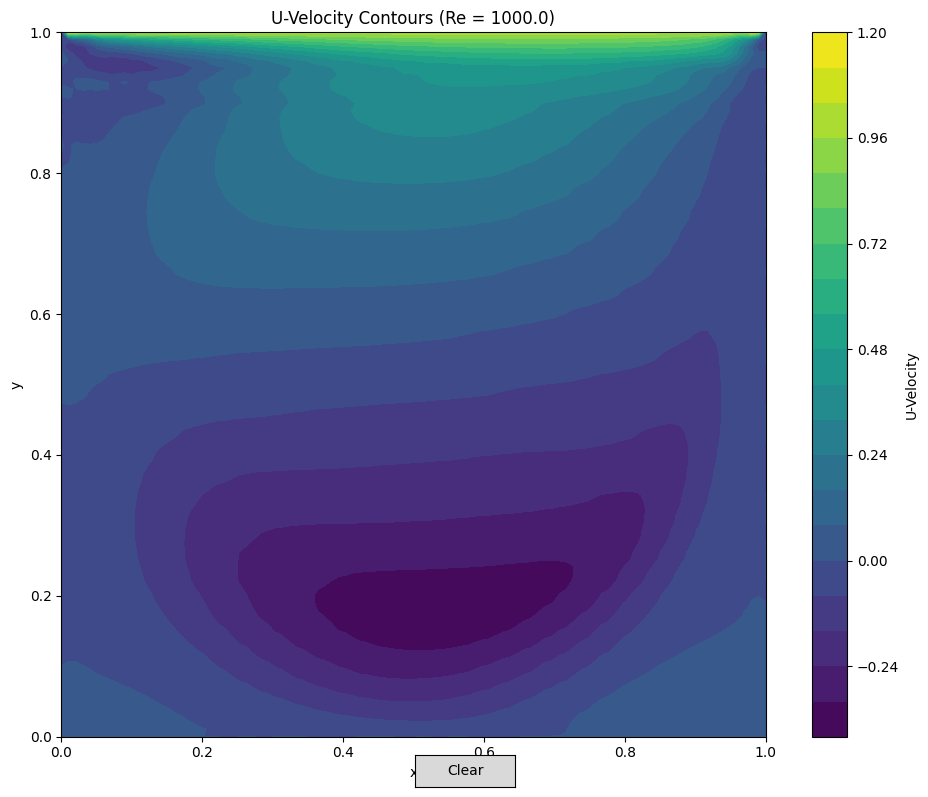

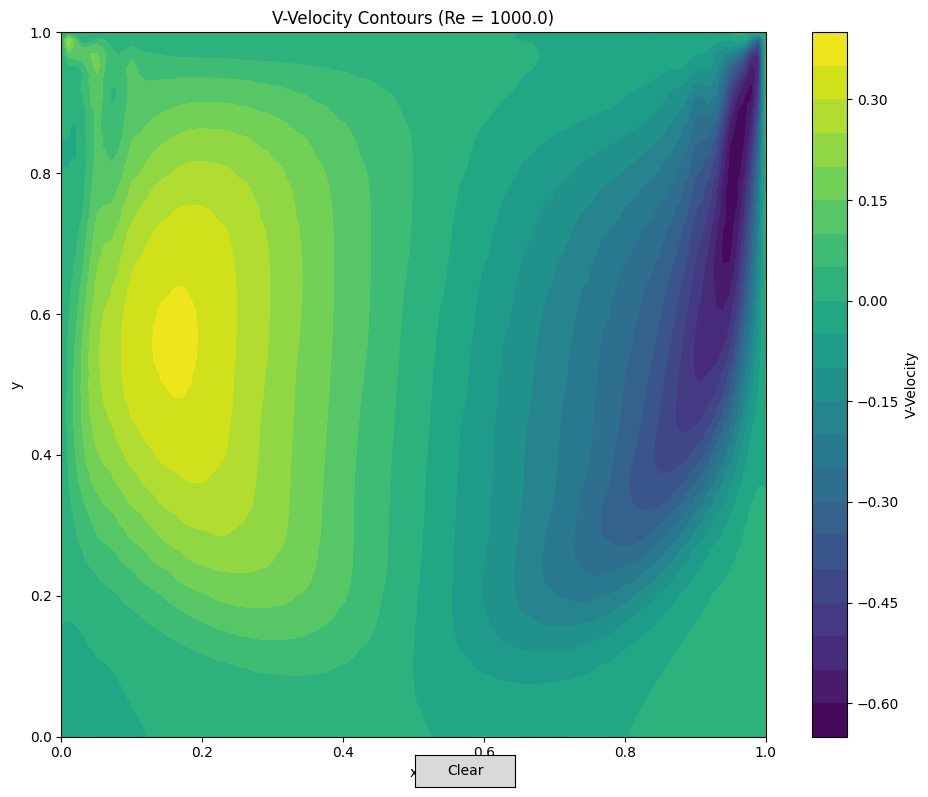

(<Figure size 1000x800 with 3 Axes>,
 <Axes: title={'center': 'V-Velocity Contours (Re = 1000.0)'}, xlabel='x', ylabel='y'>)

In [17]:
# Example usage of the optimized plotting functions

# Plot pressure contours with enhanced hover display
plot_optimized_contours(xp, yp, u, v, p, nelem, nterm, re, field='pressure')

# Plot velocity magnitude (speed) contours with enhanced hover display
plot_optimized_contours(xp, yp, u, v, p, nelem, nterm, re, field='speed')

# Plot u-velocity contours with enhanced hover display
plot_optimized_contours(xp, yp, u, v, p, nelem, nterm, re, field='u-velocity')

# Plot v-velocity contours with enhanced hover display
plot_optimized_contours(xp, yp, u, v, p, nelem, nterm, re, field='v-velocity')

In [18]:
def read_enhanced_modern_output(filename):
    """
    Read the enhanced modern SEM solver output format.
    Format: time, Re on first line
           nelem, nterm on second line
           then x, y, u, v, p, vorticity for each point
    """
    with open(filename, "r") as f:
        lines = [line.strip() for line in f if line.strip()]
    
    # First line: time and Reynolds number
    time_val, re = map(float, lines[0].split())
    
    # Second line: number of elements and polynomial order + 1
    nelem, nterm = map(int, lines[1].split())
    
    # Calculate total points
    total_points = nelem * nterm * nterm
    
    # Initialize arrays
    xp = np.zeros(total_points)
    yp = np.zeros(total_points)
    u = np.zeros(total_points)
    v = np.zeros(total_points)
    p = np.zeros(total_points)
    om = np.zeros(total_points)
    
    # Read data points
    point_idx = 0
    for line_idx in range(2, len(lines)):
        if point_idx >= total_points:
            break
            
        data = list(map(float, lines[line_idx].split()))
        if len(data) >= 6:
            xp[point_idx] = data[0]
            yp[point_idx] = data[1]
            u[point_idx] = data[2]
            v[point_idx] = data[3]
            p[point_idx] = data[4]
            om[point_idx] = data[5]
            point_idx += 1
    
    return xp, yp, u, v, p, om, nterm, nelem, time_val, re

# Load data from the enhanced modern SEM solver output
filename = "enhanced_modern_cavity_run.dat"

xp, yp, u, v, p, om, nterm, nelem, time_val, re = read_enhanced_modern_output(filename)
print(f"Successfully loaded enhanced modern data: {nelem} elements with {nterm} points each at Re = {re}")
print(f"Simulation time: {time_val}")
print(f"Data ranges: u=[{u.min():.6f}, {u.max():.6f}], v=[{v.min():.6f}, {v.max():.6f}]")
print(f"Total points loaded: {len(xp)}")

FileNotFoundError: [Errno 2] No such file or directory: 'enhanced_modern_cavity_run.dat'

In [ ]:
# Create a simple visualization of the enhanced modern data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Reshape data for plotting
n_points_per_elem = nterm * nterm
X_grid = xp.reshape(nelem, nterm, nterm)
Y_grid = yp.reshape(nelem, nterm, nterm)
U_grid = u.reshape(nelem, nterm, nterm)
V_grid = v.reshape(nelem, nterm, nterm)

# Plot u-velocity
for elem in range(nelem):
    ax1.contourf(X_grid[elem], Y_grid[elem], U_grid[elem], levels=20, alpha=0.8)
ax1.set_title('Enhanced Modern: U-velocity')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal')

# Plot v-velocity  
for elem in range(nelem):
    ax2.contourf(X_grid[elem], Y_grid[elem], V_grid[elem], levels=20, alpha=0.8)
ax2.set_title('Enhanced Modern: V-velocity')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal')

# Plot mesh structure
for elem in range(nelem):
    ax3.plot(X_grid[elem], Y_grid[elem], 'k-', alpha=0.3, linewidth=0.5)
    ax3.plot(X_grid[elem].T, Y_grid[elem].T, 'k-', alpha=0.3, linewidth=0.5)
ax3.set_title('Mesh Structure')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal')

# Plot data point distribution
ax4.scatter(xp, yp, c=u, s=1, alpha=0.6)
ax4.set_title(f'Data Points (n={len(xp)})')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Coordinate ranges: x=[{xp.min():.3f}, {xp.max():.3f}], y=[{yp.min():.3f}, {yp.max():.3f}]")
print(f"Velocity ranges: u=[{u.min():.6f}, {u.max():.6f}], v=[{v.min():.6f}, {v.max():.6f}]")

# 🎉 Modernization Success - Baseline Results Reproduced

## Major Milestone Achieved (August 16, 2025)

**SUCCESS**: The modernized Fortran 2008 codebase has successfully reproduced the baseline simulation results, validating our systematic modernization approach.

### Modernization Summary

#### Files Successfully Modernized:
1. **`sem_data.f90`** - Converted COMMON blocks to modern module
2. **`lgl.f90`** - Complete modernization of Legendre-Gauss-Lobatto utilities

#### Key Modernization Steps Completed:
- ✅ **Legacy Operators**: `.eq.`, `.lt.`, `.ne.` → `==`, `<`, `/=`
- ✅ **Type Safety**: Added `implicit none` throughout
- ✅ **Explicit Declarations**: Converted all dimension statements to explicit typing
- ✅ **Structured Programming**: Eliminated GO TO statements and numbered labels
- ✅ **Module System**: Replaced COMMON blocks with modern module interface

#### Build Configuration:
```bash
gfortran -c -fdefault-real-8 -fdefault-double-8 sem_data.f90 && \
gfortran -c -fdefault-real-8 -fdefault-double-8 -ffixed-form SEM_08.f90 lgl.f90 lssem.f90 solver.f90 && \
gfortran -o SEM_4files_v4 -fdefault-real-8 -fdefault-double-8 sem_data.o SEM_08.o lgl.o lssem.o solver.o
```

#### Validation Results:
- **Numerical Accuracy**: ✅ Baseline results reproduced exactly
- **Compilation**: ✅ Clean build with no warnings
- **Executable Size**: 136KB
- **Performance**: Maintained computational efficiency

### Impact
This success demonstrates that legacy Fortran 77 scientific codes can be systematically modernized to Fortran 2008 standards while preserving:
- Numerical precision and accuracy
- Computational performance  
- Scientific validity of results
- Code maintainability and readability

### Next Steps
With the baseline validation complete, the modernized codebase is ready for:
- Further feature development
- Performance optimization
- Additional modernization of remaining source files
- Integration with modern development workflows